In [ ]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [1]:
print(1)

1


In [2]:
size_dict = {}
for experiment in ['BSF_01','BSF_03','BSF_04','BSF_05','BSF_06','BSF_07','BSF_08']:
    template_path = f'/cluster/majf_lab/mtinti/UTR/{experiment}/res4/{experiment}/stats/{experiment}.txt'
    for line in open(template_path):
        if 'reads mapped and paired' in line:
            #print('ok')
            mapped = line.split('paired:')[1].split('\t')[1].strip()
            #print(item, mapped)
            size_dict[experiment]=int(mapped)
            break         

In [3]:
curated = pd.read_csv('bla_corrected.txt',sep='\t')
curated['original_peak']=[n.split('.')[0] for n in curated['peak_id']]
curated.head()

,contig,start,end,peak_id,status,new_start,new_end,original_peak
0,Tb927_01_v5.1,2,501,NA_peak_109,R,NaN,NaN,NA_peak_109
1,Tb927_01_v5.1,7773,8245,NA_peak_110,R,NaN,NaN,NA_peak_110
2,Tb927_01_v5.1,12064,12387,NA_peak_111,R,NaN,NaN,NA_peak_111
3,Tb927_01_v5.1,34836,37579,NA_peak_112,R,NaN,NaN,NA_peak_112
4,Tb927_01_v5.1,37602,39904,NA_peak_113,R,NaN,NaN,NA_peak_113


In [4]:
curated['peak_id'].value_counts()

NA_peak_338     1
NA_peak_2059    1
NA_peak_511     1
NA_peak_2743    1
NA_peak_207     1
               ..
NA_peak_1466    1
NA_peak_2922    1
NA_peak_1225    1
NA_peak_2100    1
NA_peak_1300    1
Name: peak_id, Length: 3581, dtype: int64

In [5]:
#curated[curated['peak_id']=='NA_peak_609']

In [6]:
#'Tb927.1.4100'

In [7]:
original_data = pd.read_csv('../merge_macs_BSF_B/NA_peaks.xls',sep='\t',comment='#')
curated = curated.merge(original_data[['fold_enrichment','name']],how='left',left_on='original_peak',right_on='name')
curated.head()

,contig,start,end,peak_id,status,new_start,new_end,original_peak,fold_enrichment,name
0,Tb927_01_v5.1,2,501,NA_peak_109,R,NaN,NaN,NA_peak_109,19.57874,NA_peak_109
1,Tb927_01_v5.1,7773,8245,NA_peak_110,R,NaN,NaN,NA_peak_110,2.53161,NA_peak_110
2,Tb927_01_v5.1,12064,12387,NA_peak_111,R,NaN,NaN,NA_peak_111,1.52507,NA_peak_111
3,Tb927_01_v5.1,34836,37579,NA_peak_112,R,NaN,NaN,NA_peak_112,31.12123,NA_peak_112
4,Tb927_01_v5.1,37602,39904,NA_peak_113,R,NaN,NaN,NA_peak_113,10.69018,NA_peak_113


In [8]:
#curated['name'].value_counts()

In [9]:
curated.shape

(3581, 10)

In [10]:
curated['start'] = np.where(curated['new_start'].notna(), curated['new_start'], curated['start'])
curated['end'] = np.where(curated['new_end'].notna(), curated['new_end'], curated['end'])
curated['start']=curated['start'].astype(int)
curated['end']=curated['end'].astype(int)
curated.head()

,contig,start,end,peak_id,status,new_start,new_end,original_peak,fold_enrichment,name
0,Tb927_01_v5.1,2,501,NA_peak_109,R,NaN,NaN,NA_peak_109,19.57874,NA_peak_109
1,Tb927_01_v5.1,7773,8245,NA_peak_110,R,NaN,NaN,NA_peak_110,2.53161,NA_peak_110
2,Tb927_01_v5.1,12064,12387,NA_peak_111,R,NaN,NaN,NA_peak_111,1.52507,NA_peak_111
3,Tb927_01_v5.1,34836,37579,NA_peak_112,R,NaN,NaN,NA_peak_112,31.12123,NA_peak_112
4,Tb927_01_v5.1,37602,39904,NA_peak_113,R,NaN,NaN,NA_peak_113,10.69018,NA_peak_113


In [11]:
curated['peak_id']=curated['peak_id']+'_'+curated['status']

In [12]:
#curated.head()

In [13]:
bed_file=curated[['contig','start','end','peak_id']]
bed_file.to_csv('bla_peaks_final.bed', sep='\t',header=False, index=False)
!cp bla_peaks_final.bed ../bw_file/

In [14]:
bl =pd.read_csv('../blacklisted gene.csv',engine='python',header=None)
bl.columns = ['gene','reason']
bl['gene']=[n.strip() for n in bl['gene']]
print(bl.shape)
bl.tail()

(284, 2)


,gene,reason
279,Tb927.9.15950,UTR_contained
280,Tb927.9.6570,UTR_contained
281,Tb927.9.6830,UTR_contained
282,Tb927.9.7500,UTR_contained
283,Tb927.9.7850,UTR_contained


In [15]:
df = pd.read_csv('../UTRs.txt',sep='\t',header=None)
df.columns = ['Gene_id','utr5','utr3']
df['Chr']=[n.split(':')[0] if str(n) != 'nan' else np.nan for n in df['utr3'] ]
df['Start']=[n.split(':')[1].split('..')[0] if str(n) != 'nan' else np.nan for n in df['utr3']]
df['End']=[n.split(':')[1].split('..')[1] if str(n) != 'nan' else np.nan for n in df['utr3']]
df['Score']='.'
df['Strand']=['-' if str(n)[-1] == 'r' else '+' for n in df['utr3']]
df=df.dropna(subset=['End'])
df['diff'] = df['End'].astype(int)-df['Start'].astype(int)
df=df[df['diff']>=1]
df[df['Gene_id']=='Tb927.11.1110']

,Gene_id,utr5,utr3,Chr,Start,End,Score,Strand,diff
6572,Tb927.11.1110,NaN,Tb927_11_v5.1:314972..316981,Tb927_11_v5.1,314972,316981,.,+,2009


In [16]:
df[['Chr', 'Start', 'End','Gene_id', 'Score', 'Strand']].to_csv('UTR3_final.bed', sep='\t', header=False, index=False)

In [17]:
%%bash
bedtools intersect -a <(bedtools sort -i bla_peaks_final.bed) \
-b <(bedtools sort -i UTR3_final.bed) -wao > bla_peak_belongs_to_3UTR.bed

In [18]:
#use awk to select only the peaks with UTR overlap
!awk '$(NF-2) != "-1"' bla_peak_belongs_to_3UTR.bed > bla_peak_belongs_to_3UTR_filtered.bed

In [19]:
df = pd.read_csv('bla_peak_belongs_to_3UTR_filtered.bed',sep='\t',header=None)
df.columns = ['Chromosome','Peak_Start','Peak_End','Peak_Name',
              'UTR_Chromosome','UTR_Start','UTR_End','UTR_Gene_ID','UTR_Score','UTR_Strand','UTR_Peak_overlap']
del df['UTR_Score']
del df['UTR_Chromosome']
#df.head()

df_plus = df[df['UTR_Strand']=='+']
df_minus = df[df['UTR_Strand']=='-']
df_plus = df_plus.drop_duplicates(subset=['Peak_Name'],keep='first')
df_minus = df_minus.drop_duplicates(subset=['Peak_Name'],keep='last')
df = pd.concat([df_plus,df_minus])
df=df.sort_values(by=['Chromosome','Peak_Start','Peak_End'])
#df[df['Peak_Name']=='NA_peak_1371']

In [20]:
def is_fully_contained(X):
    p_start =  int(X['Peak_Start'])
    p_end =  int(X['Peak_End'])
    u_start =  int(X['UTR_Start'])
    u_end =  int(X['UTR_End'])
    if (p_start>=u_start) and (p_end<=u_end):
        return True
    else:
        return False
df['is_fully_contained'] = df.apply(is_fully_contained,axis=1)

In [21]:
def format_download(X):
    if X['UTR_Strand']=='-':
        orient = 'r'
    else:
        orient = 'f'
    chro =  X['Chromosome']  
    p_start =  int(X['Peak_Start'])
    p_end =  int(X['Peak_End'])
    u_start =  int(X['UTR_Start'])
    u_end =  int(X['UTR_End'])  
    
    start = max(p_start,u_start)
    end = min(p_end,u_end)
    download_string = f'{chro}:{start}..{end}:{orient}'
    return download_string   
df['download_string_overlap_sense']=df.apply(format_download,axis=1)

In [22]:
def format_download(X):
    if X['UTR_Strand']=='-':
        orient = 'f'
    else:
        orient = 'r'
    chro =  X['Chromosome']  
    p_start =  int(X['Peak_Start'])
    p_end =  int(X['Peak_End'])
    u_start =  int(X['UTR_Start'])
    u_end =  int(X['UTR_End'])  
    
    start = max(p_start,u_start)
    end = min(p_end,u_end)
    download_string = f'{chro}:{start}..{end}:{orient}'
    return download_string   
df['download_string_overlap_syntenic']=df.apply(format_download,axis=1)

In [23]:
df[df['Peak_Name']=='NA_peak_1452_G']

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,download_string_overlap_sense,download_string_overlap_syntenic
935,Tb927_07_v5.1,974192,976101,NA_peak_1452_G,974457,975100,Tb927.7.3720,+,643,False,Tb927_07_v5.1:974457..975100:f,Tb927_07_v5.1:974457..975100:r
936,Tb927_07_v5.1,974192,976101,NA_peak_1452_G,975136,976288,Tb927.7.3730,-,965,False,Tb927_07_v5.1:975136..976101:r,Tb927_07_v5.1:975136..976101:f


In [24]:
#df[df['UTR_Gene_ID'].isin(['Tb927.1.4050'])]

In [25]:
#df[df['Peak_Name']=='NA_peak_2703_G_Tb927.10.8230']

In [26]:
#df['Peak_Name'].value_counts().head(9)
df['Peak_Name']=df['Peak_Name']+'_'+df['UTR_Gene_ID']

In [27]:
#df[df['Peak_Name']=='NA_peak_1069_G']

In [28]:
#df[df['Peak_Name']=='NA_peak_609']
df.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,download_string_overlap_sense,download_string_overlap_syntenic
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,Tb927_01_v5.1:69661..69903:r,Tb927_01_v5.1:69661..69903:f
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,Tb927_01_v5.1:85611..85853:r,Tb927_01_v5.1:85611..85853:f
3,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,Tb927_01_v5.1:204160..204347:r,Tb927_01_v5.1:204160..204347:f
4,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,Tb927_01_v5.1:232038..232503:r,Tb927_01_v5.1:232038..232503:f
5,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,Tb927_01_v5.1:263913..264334:r,Tb927_01_v5.1:263913..264334:f


In [29]:
def load_fasta_sequences(fasta_path):
    sequences = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        sequences[record.id] = record.seq
    return sequences

def extract_region_from_dict(region_descriptor):
    chromosome_id, start_end, orientation = region_descriptor.split(':')
    
    start = int(start_end.split('..')[0])
    end = int(start_end.split('..')[1])
    
    if chromosome_id in sequences:
        sequence = sequences[chromosome_id][start-1:end]
        if orientation == 'r':
            sequence = sequence.reverse_complement()
        seq_record = SeqRecord(sequence, id=region_descriptor, description="")
        return seq_record.format("fasta")
    return None

# Usage with DataFrame
fasta_path = "../TriTrypDB-62_TbruceiTREU927_Genome.fasta"
sequences = load_fasta_sequences(fasta_path)

# Assuming 'df' is your DataFrame and 'coords' is the column with the genomic coordinates
df['fasta_sequences_overlap_sense'] = df['download_string_overlap_sense'].apply(extract_region_from_dict)
df.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,download_string_overlap_sense,download_string_overlap_syntenic,fasta_sequences_overlap_sense
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,Tb927_01_v5.1:69661..69903:r,Tb927_01_v5.1:69661..69903:f,>Tb927_01_v5.1:69661..69903:r\nGGTGTGGAAGGAAAG...
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,Tb927_01_v5.1:85611..85853:r,Tb927_01_v5.1:85611..85853:f,>Tb927_01_v5.1:85611..85853:r\nGGTGTGGAAGGAAAG...
3,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,Tb927_01_v5.1:204160..204347:r,Tb927_01_v5.1:204160..204347:f,>Tb927_01_v5.1:204160..204347:r\nCGCGAAGAAAGAT...
4,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,Tb927_01_v5.1:232038..232503:r,Tb927_01_v5.1:232038..232503:f,>Tb927_01_v5.1:232038..232503:r\nACTTCCAGAAAAA...
5,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,Tb927_01_v5.1:263913..264334:r,Tb927_01_v5.1:263913..264334:f,>Tb927_01_v5.1:263913..264334:r\nCACTCGGGTAGGG...


In [30]:
df['fasta_sequences_overlap_syntenic'] = df['download_string_overlap_syntenic'].apply(extract_region_from_dict)
df.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,download_string_overlap_sense,download_string_overlap_syntenic,fasta_sequences_overlap_sense,fasta_sequences_overlap_syntenic
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,Tb927_01_v5.1:69661..69903:r,Tb927_01_v5.1:69661..69903:f,>Tb927_01_v5.1:69661..69903:r\nGGTGTGGAAGGAAAG...,>Tb927_01_v5.1:69661..69903:f\nCAATGTTCTGTCGTA...
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,Tb927_01_v5.1:85611..85853:r,Tb927_01_v5.1:85611..85853:f,>Tb927_01_v5.1:85611..85853:r\nGGTGTGGAAGGAAAG...,>Tb927_01_v5.1:85611..85853:f\nCAATGTTCTGTCGTA...
3,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,Tb927_01_v5.1:204160..204347:r,Tb927_01_v5.1:204160..204347:f,>Tb927_01_v5.1:204160..204347:r\nCGCGAAGAAAGAT...,>Tb927_01_v5.1:204160..204347:f\nTATTTTCGTTGTT...
4,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,Tb927_01_v5.1:232038..232503:r,Tb927_01_v5.1:232038..232503:f,>Tb927_01_v5.1:232038..232503:r\nACTTCCAGAAAAA...,>Tb927_01_v5.1:232038..232503:f\nATCTCCCACTCAG...
5,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,Tb927_01_v5.1:263913..264334:r,Tb927_01_v5.1:263913..264334:f,>Tb927_01_v5.1:263913..264334:r\nCACTCGGGTAGGG...,>Tb927_01_v5.1:263913..264334:f\nACATGCACGTGCT...


In [31]:
#make SAF file to get read counts
SAF_df = df[['Peak_Name','Chromosome','Peak_Start','Peak_End']].copy()
SAF_df.head()

,Peak_Name,Chromosome,Peak_Start,Peak_End
0,NA_peak_118_G_Tb927.1.180,Tb927_01_v5.1,69142,70745
1,NA_peak_120_G_Tb927.1.220,Tb927_01_v5.1,85602,86127
3,NA_peak_125_G_Tb927.1.540,Tb927_01_v5.1,202075,204347
4,NA_peak_126_G_Tb927.1.700,Tb927_01_v5.1,232038,232950
5,NA_peak_129_G_Tb927.1.880,Tb927_01_v5.1,263873,264334


In [32]:
SAF_df['Peak_Start']=SAF_df['Peak_Start']+50
SAF_df['Peak_End']=SAF_df['Peak_End']-50

In [33]:
SAF_df.head()

,Peak_Name,Chromosome,Peak_Start,Peak_End
0,NA_peak_118_G_Tb927.1.180,Tb927_01_v5.1,69192,70695
1,NA_peak_120_G_Tb927.1.220,Tb927_01_v5.1,85652,86077
3,NA_peak_125_G_Tb927.1.540,Tb927_01_v5.1,202125,204297
4,NA_peak_126_G_Tb927.1.700,Tb927_01_v5.1,232088,232900
5,NA_peak_129_G_Tb927.1.880,Tb927_01_v5.1,263923,264284


In [34]:
#shorten the peaks to avoid counts of adjacent peak index reads
#print(SAF_df[SAF_df['Peak_Name']=='NA_peak_609'])
#SAF_df['Peak_Start']=SAF_df['Peak_Start']+20
#print(SAF_df[SAF_df['Peak_Name']=='NA_peak_609'])
SAF_df.columns = ['GeneID','Chr','Start','End']
SAF_df['Strand']='.'
SAF_df.to_csv('B.SAF',sep='\t',index=False)
SAF_df.head()

,GeneID,Chr,Start,End,Strand
0,NA_peak_118_G_Tb927.1.180,Tb927_01_v5.1,69192,70695,.
1,NA_peak_120_G_Tb927.1.220,Tb927_01_v5.1,85652,86077,.
3,NA_peak_125_G_Tb927.1.540,Tb927_01_v5.1,202125,204297,.
4,NA_peak_126_G_Tb927.1.700,Tb927_01_v5.1,232088,232900,.
5,NA_peak_129_G_Tb927.1.880,Tb927_01_v5.1,263923,264284,.


In [35]:
#df[df['Peak_Name']=='NA_peak_609']

In [36]:
#SAF_df[SAF_df['GeneID']=='NA_peak_609']

In [37]:
#SAF_df.shape

In [38]:
#!less utr.SAF
#-B requireBothEndsMapped
#-C countChimericFragments (excluded)
#-M countMultiMappingReads (true)

In [39]:
#we now count the read pairs for each B samples and barcoded B samples
!featureCounts -p -B -C -M -T 16 -F SAF -a 'B.SAF' \
-o 'B_counts.txt' \
/cluster/majf_lab/mtinti/UTR/BSF_01/res4/BSF_01/BSF_01_sorted.bam \
/cluster/majf_lab/mtinti/UTR/BSF_03/res4/BSF_03/BSF_03_sorted.bam \
/cluster/majf_lab/mtinti/UTR/BSF_04/res4/BSF_04/BSF_04_sorted.bam \
/cluster/majf_lab/mtinti/UTR/BSF_05/res4/BSF_05/BSF_05_sorted.bam \
/cluster/majf_lab/mtinti/UTR/BSF_06/res4/BSF_06/BSF_06_sorted.bam \
/cluster/majf_lab/mtinti/UTR/BSF_07/res4/BSF_07/BSF_07_sorted.bam \
/cluster/majf_lab/mtinti/UTR/BSF_08/res4/BSF_08/BSF_08_sorted.bam \
/cluster/majf_lab/mtinti/UTR/BSF_01/res4/BSF_01/BSF_01_sorted_F.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_01/res4/BSF_01/BSF_01_sorted_R.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_01/res4/BSF_01/BSF_01_sorted_FR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_01/res4/BSF_01/BSF_01_sorted_RR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_03/res4/BSF_03/BSF_03_sorted_F.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_03/res4/BSF_03/BSF_03_sorted_R.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_03/res4/BSF_03/BSF_03_sorted_FR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_03/res4/BSF_03/BSF_03_sorted_RR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_04/res4/BSF_04/BSF_04_sorted_F.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_04/res4/BSF_04/BSF_04_sorted_R.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_04/res4/BSF_04/BSF_04_sorted_FR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_04/res4/BSF_04/BSF_04_sorted_RR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_05/res4/BSF_05/BSF_05_sorted_F.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_05/res4/BSF_05/BSF_05_sorted_R.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_05/res4/BSF_05/BSF_05_sorted_FR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_05/res4/BSF_05/BSF_05_sorted_RR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_06/res4/BSF_06/BSF_06_sorted_F.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_06/res4/BSF_06/BSF_06_sorted_R.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_06/res4/BSF_06/BSF_06_sorted_FR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_06/res4/BSF_06/BSF_06_sorted_RR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_07/res4/BSF_07/BSF_07_sorted_F.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_07/res4/BSF_07/BSF_07_sorted_R.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_07/res4/BSF_07/BSF_07_sorted_FR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_07/res4/BSF_07/BSF_07_sorted_RR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_08/res4/BSF_08/BSF_08_sorted_F.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_08/res4/BSF_08/BSF_08_sorted_R.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_08/res4/BSF_08/BSF_08_sorted_FR.bam  \
/cluster/majf_lab/mtinti/UTR/BSF_08/res4/BSF_08/BSF_08_sorted_RR.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.4

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 35 BAM files                                     ||
||                           P BSF_01_sorted.bam                              ||
||                           P BSF_03_sorted.bam                              ||
||                           P BSF_04_sorted.bam                              ||
||                           P BSF_05_sorted.bam                 

In [39]:
counts = pd.read_csv('B_counts.txt',comment='#',sep='\t',index_col=[0])
counts_col = list(counts.columns[5:])
new_names = [n.split('/')[-1].split('.')[0].replace('_sorted','') for n in counts_col]
new_names = dict(zip(counts_col, new_names))
counts = counts.rename(new_names,axis=1)
counts.head()

,Chr,Start,End,Strand,Length,BSF_01,BSF_03,BSF_04,BSF_05,BSF_06,...,BSF_06_FR,BSF_06_RR,BSF_07_F,BSF_07_R,BSF_07_FR,BSF_07_RR,BSF_08_F,BSF_08_R,BSF_08_FR,BSF_08_RR
Geneid,,,,,,,,,,,,,,,,,,,,,
NA_peak_118_G_Tb927.1.180,Tb927_01_v5.1,69192,70695,.,1504,9108,7810,6143,6061,9691,...,15,66,168,73,6,58,229,75,27,71
NA_peak_120_G_Tb927.1.220,Tb927_01_v5.1,85652,86077,.,426,3474,2730,2336,2272,2926,...,1,5,152,91,5,8,170,99,16,17
NA_peak_125_G_Tb927.1.540,Tb927_01_v5.1,202125,204297,.,2173,5175,11674,6207,4745,1909,...,27,9,0,7,7,4,0,9,9,7
NA_peak_126_G_Tb927.1.700,Tb927_01_v5.1,232088,232900,.,813,75,1310,877,747,408,...,0,1,16,0,0,7,4,0,1,3
NA_peak_129_G_Tb927.1.880,Tb927_01_v5.1,263923,264284,.,362,273,3651,1615,1569,36,...,1,0,0,2,0,0,0,6,0,0


In [40]:
counts.tail()

,Chr,Start,End,Strand,Length,BSF_01,BSF_03,BSF_04,BSF_05,BSF_06,...,BSF_06_FR,BSF_06_RR,BSF_07_F,BSF_07_R,BSF_07_FR,BSF_07_RR,BSF_08_F,BSF_08_R,BSF_08_FR,BSF_08_RR
Geneid,,,,,,,,,,,,,,,,,,,,,
NA_peak_4472_R_Tb927.11.16940,Tb927_11_v5.1,4516602,4517361,.,760,8,156,7,176,71,...,0,0,0,2,0,0,0,0,0,0
NA_peak_4473_G_Tb927.11.16970,Tb927_11_v5.1,4525001,4526277,.,1277,254,4356,1027,265,467,...,0,11,16,2,0,7,14,7,2,5
NA_peak_4475_G_Tb927.11.17000,Tb927_11_v5.1,4530182,4531791,.,1610,927,10929,13471,19257,762,...,1,12,6,0,0,3,8,0,2,1
NA_peak_4476_R_Tb927.11.17000,Tb927_11_v5.1,4532048,4532412,.,365,20,164,445,20,40,...,0,0,0,0,0,0,0,0,0,0
NA_peak_4558_R_Tb927.11.18250,Tb927_11_v5.1,4951608,4952228,.,621,566,886,691,960,890,...,0,0,0,1,0,0,0,0,0,0


In [41]:
counts['B_iF_03'] = counts[['BSF_03_F','BSF_03_RR']].sum(axis=1).astype(int)
counts['B_iF_04'] = counts[['BSF_04_F','BSF_04_RR']].sum(axis=1).astype(int)
counts['B_iF_05'] = counts[['BSF_05_F','BSF_05_RR']].sum(axis=1).astype(int)

counts['G_iF_06'] = counts[['BSF_06_F','BSF_06_RR']].sum(axis=1).astype(int)
counts['G_iF_07'] = counts[['BSF_07_F','BSF_07_RR']].sum(axis=1).astype(int)
counts['G_iF_08'] = counts[['BSF_08_F','BSF_08_RR']].sum(axis=1).astype(int)

counts['B_iR_03'] = counts[['BSF_03_R','BSF_03_FR']].sum(axis=1).astype(int)
counts['B_iR_04'] = counts[['BSF_04_R','BSF_04_FR']].sum(axis=1).astype(int)
counts['B_iR_05'] = counts[['BSF_05_R','BSF_05_FR']].sum(axis=1).astype(int)

counts['G_iR_06'] = counts[['BSF_06_R','BSF_06_FR']].sum(axis=1).astype(int)
counts['G_iR_07'] = counts[['BSF_07_R','BSF_07_FR']].sum(axis=1).astype(int)
counts['G_iR_08'] = counts[['BSF_08_R','BSF_08_FR']].sum(axis=1).astype(int)
counts.head()

,Chr,Start,End,Strand,Length,BSF_01,BSF_03,BSF_04,BSF_05,BSF_06,...,B_iF_05,G_iF_06,G_iF_07,G_iF_08,B_iR_03,B_iR_04,B_iR_05,G_iR_06,G_iR_07,G_iR_08
Geneid,,,,,,,,,,,,,,,,,,,,,
NA_peak_118_G_Tb927.1.180,Tb927_01_v5.1,69192,70695,.,1504,9108,7810,6143,6061,9691,...,297,268,226,300,255,187,161,128,79,102
NA_peak_120_G_Tb927.1.220,Tb927_01_v5.1,85652,86077,.,426,3474,2730,2336,2272,2926,...,177,169,160,187,72,67,52,70,96,115
NA_peak_125_G_Tb927.1.540,Tb927_01_v5.1,202125,204297,.,2173,5175,11674,6207,4745,1909,...,127,12,4,7,268,103,62,41,14,18
NA_peak_126_G_Tb927.1.700,Tb927_01_v5.1,232088,232900,.,813,75,1310,877,747,408,...,2,19,23,7,93,47,49,0,0,1
NA_peak_129_G_Tb927.1.880,Tb927_01_v5.1,263923,264284,.,362,273,3651,1615,1569,36,...,204,1,0,0,5,2,0,1,2,6


In [42]:
counts['Peak_Name']=counts.index.values

In [43]:
counts = counts.merge(df[['Peak_Name','UTR_Strand']],how='left',left_on='Peak_Name',right_on='Peak_Name')
counts.shape

(2233, 54)

In [44]:
prot_rank_F = counts[['BSF_03_F','BSF_03_RR',
                      'BSF_04_F','BSF_04_RR',
                      'BSF_05_F','BSF_05_RR',
                      'BSF_06_F','BSF_06_RR',
                      'BSF_07_F','BSF_07_RR',
                      'BSF_08_F','BSF_08_RR',
                      'Peak_Name',
                      'UTR_Strand']]
prot_rank_R = counts[['BSF_03_R','BSF_03_FR',
                      'BSF_04_R','BSF_04_FR',
                      'BSF_05_R','BSF_05_FR',
                      'BSF_06_R','BSF_06_FR',
                      'BSF_07_R','BSF_07_FR',
                      'BSF_08_R','BSF_08_FR',
                      'Peak_Name',
                      'UTR_Strand']]
prot_rank_F.shape,prot_rank_R.shape

((2233, 14), (2233, 14))

In [45]:
counts.shape,prot_rank_F.shape,prot_rank_R.shape

((2233, 54), (2233, 14), (2233, 14))

In [46]:
#prot_rank_F.head()

In [47]:
#prot_rank_F[prot_rank_F['Peak_Name']=='NA_peak_609']

In [48]:
prot_rank_F.set_index('Peak_Name',inplace=True)
prot_rank_R.set_index('Peak_Name',inplace=True)

prot_rank_sense_1 = prot_rank_F[prot_rank_F['UTR_Strand']=='+']
prot_rank_sense_2 = prot_rank_R[prot_rank_R['UTR_Strand']=='-']
del prot_rank_sense_1['UTR_Strand']
del prot_rank_sense_2['UTR_Strand']
prot_rank_sense_1.columns = ['B1','B2','B3','B4','B5','B6','G1','G2','G3','G4','G5','G6']
prot_rank_sense_2.columns = ['B1','B2','B3','B4','B5','B6','G1','G2','G3','G4','G5','G6']
prot_rank_sense=pd.concat([prot_rank_sense_1,prot_rank_sense_2])


prot_rank_synthetic_1 = prot_rank_F[prot_rank_F['UTR_Strand']=='-']
prot_rank_synthetic_2 = prot_rank_R[prot_rank_R['UTR_Strand']=='+']
del prot_rank_synthetic_1['UTR_Strand']
del prot_rank_synthetic_2['UTR_Strand']
prot_rank_synthetic_1.columns = ['B1','B2','B3','B4','B5','B6','G1','G2','G3','G4','G5','G6']
prot_rank_synthetic_2.columns = ['B1','B2','B3','B4','B5','B6','G1','G2','G3','G4','G5','G6']
prot_rank_synthetic=pd.concat([prot_rank_synthetic_1, prot_rank_synthetic_2])


prot_rank_sense.fillna(0).to_csv('in_prot_rank_Sense2.csv')
prot_rank_synthetic.fillna(0).to_csv('in_prot_rank_Synthetic2.csv')

In [49]:
prot_rank_sense.shape,prot_rank_synthetic.shape

((2233, 12), (2233, 12))

In [50]:
prot_rank_sense.head()

,B1,B2,B3,B4,B5,B6,G1,G2,G3,G4,G5,G6
Peak_Name,,,,,,,,,,,,
NA_peak_132_G_Tb927.1.1080,5,2,2,0,0,1,3,2,2,0,1,0
NA_peak_133_G_Tb927.1.1240,5,2,7,2,1,5,0,0,0,0,0,0
NA_peak_134_R_Tb927.1.1240,0,0,0,0,0,0,0,0,0,0,0,0
NA_peak_135_G_Tb927.1.1300,92,84,57,47,15,22,123,116,22,20,16,24
NA_peak_136_G_Tb927.1.1380,0,1,0,1,0,0,0,0,1,0,1,1


In [51]:
import matplotlib.pyplot as plt
prot_rank_sense.plot(kind='box',showfliers=False)
plt.show()

<Figure size 640x480 with 1 Axes>

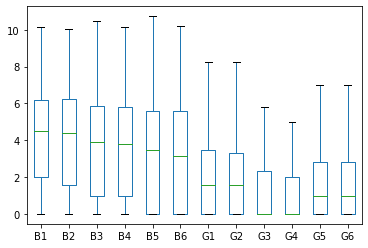

In [52]:
import matplotlib.pyplot as plt
np.log2(prot_rank_sense+1).plot(kind='box',showfliers=False)
plt.show()

In [53]:
#norm_sense = sklearn.preprocessing.quantile_transform(prot_rank_sense)
#norm_sense = pd.DataFrame(norm_sense,columns =prot_rank_sense.columns,index=prot_rank_sense.index.values)
#norm_sense

In [54]:
#prot_rank_sense.loc['NA_peak_4380'],prot_rank_synthetic.loc['NA_peak_4380']

In [55]:
size_dict
#np.log10(57045590)

{'BSF_01': 57045590,
 'BSF_03': 44041520,
 'BSF_04': 33926564,
 'BSF_05': 35432770,
 'BSF_06': 70786836,
 'BSF_07': 56237448,
 'BSF_08': 64461908}

In [56]:
57045590
10 000 000

10000000

In [57]:
normed_sense = prot_rank_sense.copy()
normed_sense['B1']=((normed_sense['B1']/size_dict['BSF_03'])*10000000).astype(int)
normed_sense['B2']=((normed_sense['B2']/size_dict['BSF_03'])*10000000).astype(int)
normed_sense['B3']=((normed_sense['B3']/size_dict['BSF_04'])*10000000).astype(int)
normed_sense['B4']=((normed_sense['B4']/size_dict['BSF_04'])*10000000).astype(int)
normed_sense['B5']=((normed_sense['B5']/size_dict['BSF_05'])*10000000).astype(int)
normed_sense['B6']=((normed_sense['B6']/size_dict['BSF_05'])*10000000).astype(int)

normed_sense['G1']=((normed_sense['G1']/size_dict['BSF_06'])*10000000).astype(int)
normed_sense['G2']=((normed_sense['G2']/size_dict['BSF_06'])*10000000).astype(int)
normed_sense['G3']=((normed_sense['G3']/size_dict['BSF_07'])*10000000).astype(int)
normed_sense['G4']=((normed_sense['G4']/size_dict['BSF_07'])*10000000).astype(int)
normed_sense['G5']=((normed_sense['G5']/size_dict['BSF_08'])*10000000).astype(int)
normed_sense['G6']=((normed_sense['G6']/size_dict['BSF_08'])*10000000).astype(int)

print(normed_sense.shape)
filter_id = [True if '_G_' in n else False for n in normed_sense.index.values]
normed_sense=normed_sense[filter_id]
print(normed_sense.shape)
normed_sense.head()

(2233, 12)
(1941, 12)


,B1,B2,B3,B4,B5,B6,G1,G2,G3,G4,G5,G6
Peak_Name,,,,,,,,,,,,
NA_peak_132_G_Tb927.1.1080,1,0,0,0,0,0,0,0,0,0,0,0
NA_peak_133_G_Tb927.1.1240,1,0,2,0,0,1,0,0,0,0,0,0
NA_peak_135_G_Tb927.1.1300,20,19,16,13,4,6,17,16,3,3,2,3
NA_peak_136_G_Tb927.1.1380,0,0,0,0,0,0,0,0,0,0,0,0
NA_peak_137_G_Tb927.1.1380,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
#ranksums??

In [59]:
#normed_sense=np.log2(normed_sense+1)
#normed_sense.head()

In [60]:
#normed_synthetic = ((prot_rank_synthetic/prot_rank_synthetic.sum())*1000000).copy().astype(int)
normed_synthetic = prot_rank_synthetic.copy()
normed_synthetic['B1']=((normed_synthetic['B1']/size_dict['BSF_03'])*10000000).astype(int)
normed_synthetic['B2']=((normed_synthetic['B2']/size_dict['BSF_03'])*10000000).astype(int)
normed_synthetic['B3']=((normed_synthetic['B3']/size_dict['BSF_04'])*10000000).astype(int)
normed_synthetic['B4']=((normed_synthetic['B4']/size_dict['BSF_04'])*10000000).astype(int)
normed_synthetic['B5']=((normed_synthetic['B5']/size_dict['BSF_05'])*10000000).astype(int)
normed_synthetic['B6']=((normed_synthetic['B6']/size_dict['BSF_05'])*10000000).astype(int)


normed_synthetic['G1']=((normed_synthetic['G1']/size_dict['BSF_06'])*10000000).astype(int)
normed_synthetic['G2']=((normed_synthetic['G2']/size_dict['BSF_06'])*10000000).astype(int)
normed_synthetic['G3']=((normed_synthetic['G3']/size_dict['BSF_07'])*10000000).astype(int)
normed_synthetic['G4']=((normed_synthetic['G4']/size_dict['BSF_07'])*10000000).astype(int)
normed_synthetic['G5']=((normed_synthetic['G5']/size_dict['BSF_08'])*10000000).astype(int)
normed_synthetic['G6']=((normed_synthetic['G6']/size_dict['BSF_08'])*10000000).astype(int)

print(normed_synthetic.shape)
filter_id = [True if '_G_' in n else False for n in normed_synthetic.index.values]
normed_synthetic=normed_synthetic[filter_id]
print(normed_synthetic.shape)
normed_synthetic.head()

(2233, 12)
(1941, 12)


,B1,B2,B3,B4,B5,B6,G1,G2,G3,G4,G5,G6
Peak_Name,,,,,,,,,,,,
NA_peak_118_G_Tb927.1.180,28,41,28,53,36,47,28,9,29,10,35,11
NA_peak_120_G_Tb927.1.220,45,0,57,0,49,0,23,0,27,1,26,2
NA_peak_125_G_Tb927.1.540,27,24,25,26,17,18,0,1,0,0,0,1
NA_peak_126_G_Tb927.1.700,0,0,0,0,0,0,2,0,2,1,0,0
NA_peak_129_G_Tb927.1.880,62,42,40,28,33,23,0,0,0,0,0,0


In [61]:
#normed_synthetic=np.log2(normed_synthetic+1)
#normed_synthetic.head()

In [62]:
#multipletests
#        - `bonferroni` : one-step correction
#        - `sidak` : one-step correction
#        - `holm-sidak` : step down method using Sidak adjustments
#        - `holm` : step-down method using Bonferroni adjustments
#        - `simes-hochberg` : step-up method  (independent)
#        - `hommel` : closed method based on Simes tests (non-negative)
#        - `fdr_bh` : Benjamini/Hochberg  (non-negative)
#        - `fdr_by` : Benjamini/Yekutieli (negative)
#        - `fdr_tsbh` : two stage fdr correction (non-negative)
#        - `fdr_tsbky` : two stage fdr correction (non-negative)

In [64]:
from scipy.stats import ranksums, wilcoxon
_ = wilcoxon([0,0,0,0,0,0],[1,1,1,1,1,1])
_.pvalue

0.014305878435429648

In [65]:
from scipy.stats import ranksums, wilcoxon
_ = wilcoxon([0,0,0],[1,1,1])
_.pvalue

0.0832645166635504

In [66]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_rel, wilcoxon

def perform_test(df, columns_first_condition, columns_second_condition, log_offset=1e-6):
    df=df.copy()
    data_first = df[columns_first_condition]
    data_second = df[columns_second_condition]
    
    # Compute means for each condition
    mean_first = np.log2(data_first+1).mean(axis=1)
    mean_second = np.log2(data_second+1).mean(axis=1)
    
    # Perform t-test
    #t_results = ttest_ind(data_first, data_second, axis=1, nan_policy='omit', equal_var=False)
    #t_results = ttest_rel(data_first, data_second, axis=1,nan_policy='omit')
    #print(t_results)
    # Calculate directions of the differences
    pvals = []
    for x, y in zip(data_first.values,data_second.values):
        try:
            _ = wilcoxon(x, y)
            pvals.append(_.pvalue)
        except:
            pvals.append(1)
    pvals = np.array(pvals)
    
    directions = (mean_second - mean_first).apply(lambda x: 'increased' if x > 0 else 'decreased')
    
    # Log2 Fold Change (avoiding log0 by adding log_offset)
    log2_fold_change = mean_second - mean_first
    
    # Log2 Average Intensity
    log2_avg_intensity = (mean_first + mean_second) / 2 
    
    # Handle NaN p-values: exclude NaN p-values from FDR correction
    #valid_pvalues = pvals[~np.isnan(pvals)]
    #corrected_pvals = np.full(pvals, np.nan)  # Initialize full NaN array to store FDR results
    #_, corrected_pvals[~np.isnan(t_results.pvalue)], _, _ = 
    _, corrected_pvals, _, _  = multipletests(pvals, method='fdr_bh')
     
    # Add results to the DataFrame
    df['p_values'] = pvals
    df['fdr'] = corrected_pvals
    df['direction'] = directions
    df['log2_fold_change'] = log2_fold_change
    df['log2_avg_intensity'] = log2_avg_intensity
    
    return df

normed_sense = perform_test(normed_sense, ['G1', 'G2', 'G3', 'G4', 'G5', 'G6'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6'])
normed_synthetic = perform_test(normed_synthetic, ['G1', 'G2', 'G3', 'G4', 'G5', 'G6'], ['B1', 'B2', 'B3','B4', 'B5', 'B6'])


In [67]:
#normed_sense_[normed_sense_['fdr']<0.05].shape

In [68]:
#pd.Series(filter_id).value_counts()

In [69]:
filter_id = [True if '_G_' in n else False for n in df['Peak_Name'].values]
print(df.shape)
df=df[filter_id]
print(df.shape)

(2233, 14)
(1941, 14)


In [70]:
#df.merge(normed_sence.reset_index(),how='left',left_on='Peak_Name',right_on='Peak_Name').drop_duplicates(subset=['Peak_Name']).shape

In [71]:
df.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,download_string_overlap_sense,download_string_overlap_syntenic,fasta_sequences_overlap_sense,fasta_sequences_overlap_syntenic
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,Tb927_01_v5.1:69661..69903:r,Tb927_01_v5.1:69661..69903:f,>Tb927_01_v5.1:69661..69903:r\nGGTGTGGAAGGAAAG...,>Tb927_01_v5.1:69661..69903:f\nCAATGTTCTGTCGTA...
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,Tb927_01_v5.1:85611..85853:r,Tb927_01_v5.1:85611..85853:f,>Tb927_01_v5.1:85611..85853:r\nGGTGTGGAAGGAAAG...,>Tb927_01_v5.1:85611..85853:f\nCAATGTTCTGTCGTA...
3,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,Tb927_01_v5.1:204160..204347:r,Tb927_01_v5.1:204160..204347:f,>Tb927_01_v5.1:204160..204347:r\nCGCGAAGAAAGAT...,>Tb927_01_v5.1:204160..204347:f\nTATTTTCGTTGTT...
4,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,Tb927_01_v5.1:232038..232503:r,Tb927_01_v5.1:232038..232503:f,>Tb927_01_v5.1:232038..232503:r\nACTTCCAGAAAAA...,>Tb927_01_v5.1:232038..232503:f\nATCTCCCACTCAG...
5,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,Tb927_01_v5.1:263913..264334:r,Tb927_01_v5.1:263913..264334:f,>Tb927_01_v5.1:263913..264334:r\nCACTCGGGTAGGG...,>Tb927_01_v5.1:263913..264334:f\nACATGCACGTGCT...


In [72]:
df[df['UTR_Gene_ID']=='Tb927.4.2880']

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,download_string_overlap_sense,download_string_overlap_syntenic,fasta_sequences_overlap_sense,fasta_sequences_overlap_syntenic
444,Tb927_04_v5.1,764458,765486,NA_peak_694_G_Tb927.4.2880,764505,764930,Tb927.4.2880,+,425,False,Tb927_04_v5.1:764505..764930:f,Tb927_04_v5.1:764505..764930:r,>Tb927_04_v5.1:764505..764930:f\nAAGGGTAAAGGGA...,>Tb927_04_v5.1:764505..764930:r\nAAAAAGGGCGCGA...


In [73]:
normed_sense.loc['NA_peak_694_G_Tb927.4.2880']

B1                           94
B2                           70
B3                          150
B4                          112
B5                          140
B6                           99
G1                            0
G2                            0
G3                            0
G4                            0
G5                            0
G6                            0
p_values              0.0277078
fdr                   0.0518121
direction             increased
log2_fold_change        6.76027
log2_avg_intensity      3.38013
Name: NA_peak_694_G_Tb927.4.2880, dtype: object

In [74]:
prot_rank_F.loc['NA_peak_694_G_Tb927.4.2880']

BSF_03_F      414
BSF_03_RR     311
BSF_04_F      511
BSF_04_RR     383
BSF_05_F      497
BSF_05_RR     354
BSF_06_F        0
BSF_06_RR       0
BSF_07_F        2
BSF_07_RR       0
BSF_08_F        0
BSF_08_RR       3
UTR_Strand      +
Name: NA_peak_694_G_Tb927.4.2880, dtype: object

In [75]:
#prot_rank_F.sum()

In [76]:
prot_rank_F.loc['NA_peak_694_G_Tb927.4.2880']

BSF_03_F      414
BSF_03_RR     311
BSF_04_F      511
BSF_04_RR     383
BSF_05_F      497
BSF_05_RR     354
BSF_06_F        0
BSF_06_RR       0
BSF_07_F        2
BSF_07_RR       0
BSF_08_F        0
BSF_08_RR       3
UTR_Strand      +
Name: NA_peak_694_G_Tb927.4.2880, dtype: object

In [77]:
#duplicate = df['Peak_Name'].value_counts()
#duplicate = set(duplicate[duplicate>1].index.values)
#df[df['Peak_Name'].isin(duplicate)]

In [78]:
#normed_sence

In [79]:
print(df.shape)
df_sense = df.merge(normed_sense.reset_index(),left_on='Peak_Name',right_on='Peak_Name')
print(df_sense.shape)
df_sense.head()

(1941, 14)
(1941, 31)


,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G2,G3,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,2,12,1,11,4,0.224916,0.276130,increased,1.684056,3.540744
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0,16,0,15,2,0.461451,0.522870,decreased,-0.144178,2.093636
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,3,1,1,1,1,0.027281,0.051812,increased,2.843776,2.588555
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,0,0,0,0,0.027708,0.051812,increased,2.969589,1.484794
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0,0,0.317311,0.367044,increased,0.166667,0.083333


In [80]:
df_sense[df_sense['fdr']<0.1].shape

(1197, 31)

In [83]:
df_sense[(df_sense['fdr']<0.1) & (df_sense['log2_fold_change']>0)]['log2_fold_change'].min()

0.3932158245586401

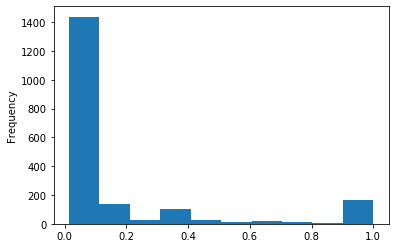

In [84]:
(df_sense['p_values']).plot(kind='hist',bins=10)

In [85]:
literature = df_sense[df_sense['UTR_Gene_ID'].isin([
    'Tb927.4.560',
    'Tb927.3.930',
    'Tb927.4.870',
    'Tb927.1.700',
    'Tb927.11.3620',
    'Tb927.10.8490',
    'Tb927.4.2310',
    'Tb927.4.2880',
    'Tb927.7.2660',
    'Tb927.9.2470',
    'Tb927.10.2010',
    'Tb927.11.8990',
    'Tb927.11.14250',
    'Tb927.2.6000',
    'Tb927.8.2780',
    'Tb927.10.3800',
    'Tb927.11.11330',
    'Tb927.11.12100',
    'Tb927.8.6750',
    'Tb927.5.800',
    'Tb927.10.5620'
])]
literature.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G2,G3,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,0,0,0,0,0.027708,0.051812,increased,2.969589,1.484794
128,Tb927_02_v5.1,1089710,1091101,NA_peak_331_G_Tb927.2.6000,1089430,1091906,Tb927.2.6000,+,1391,True,...,0,0,0,0,0,0.027281,0.051812,increased,3.532049,1.766024
142,Tb927_03_v5.1,231006,231932,NA_peak_399_G_Tb927.3.930,231262,231722,Tb927.3.930,+,460,False,...,0,0,0,0,0,0.027708,0.051812,increased,6.276303,3.138152
284,Tb927_04_v5.1,150350,152196,NA_peak_614_G_Tb927.4.560,151286,151602,Tb927.4.560,-,316,False,...,0,0,0,0,0,0.027708,0.051812,increased,7.248204,3.624102
291,Tb927_04_v5.1,237031,237994,NA_peak_624_G_Tb927.4.870,237697,238337,Tb927.4.870,-,297,False,...,0,0,0,0,0,0.027708,0.051812,increased,4.606080,2.303040


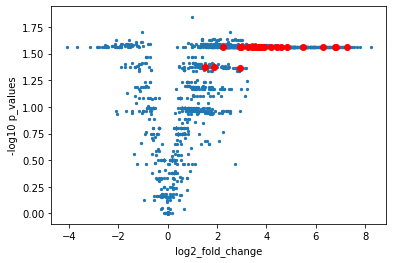

In [87]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.scatter(df_sense['log2_fold_change'], -np.log10(df_sense['p_values'] ), s=5)
ax.scatter(literature['log2_fold_change'], -np.log10(literature['p_values']),c='r' ,label='Literature')
plt.xlabel('log2_fold_change')
plt.ylabel('-log10 p_values')
plt.show()

In [83]:
##-np.log10(0.05)

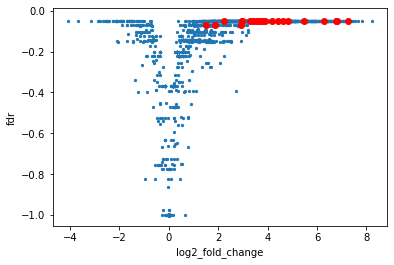

In [89]:
fig,ax=plt.subplots()
ax.scatter(df_sense['log2_fold_change'], -df_sense['fdr'], s=5)
ax.scatter(literature['log2_fold_change'], -literature['fdr'], c='r' )
plt.xlabel('log2_fold_change')
plt.ylabel('fdr')
plt.show()

In [90]:
#-np.log10(0.1)
df_sense[ (df_sense['log2_fold_change']>0) & (df_sense['fdr']<0.1)].shape

(1112, 31)

In [91]:

#'Tb927.10.5620' manual adjust peak
#'Tb927.5.120' just a few reads, unmappable
#'Tb927.11.8990' low after norm
#'Tb927.9.8880' peak not called high control
#'Tb927.1.4100' peak not called high control
#'Tb927.10.8320' no peak call



In [92]:
np.array(df_sense.columns)

array(['Chromosome', 'Peak_Start', 'Peak_End', 'Peak_Name', 'UTR_Start',
       'UTR_End', 'UTR_Gene_ID', 'UTR_Strand', 'UTR_Peak_overlap',
       'is_fully_contained', 'download_string_overlap_sense',
       'download_string_overlap_syntenic',
       'fasta_sequences_overlap_sense',
       'fasta_sequences_overlap_syntenic', 'B1', 'B2', 'B3', 'B4', 'B5',
       'B6', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'p_values', 'fdr',
       'direction', 'log2_fold_change', 'log2_avg_intensity'],
      dtype=object)

In [93]:
del df_sense['download_string_overlap_syntenic']
del df_sense['fasta_sequences_overlap_syntenic']

In [94]:
df_sense.to_csv('final_sense2.csv')

In [95]:
print(df.shape)
df_synthetic = df.merge(normed_synthetic.reset_index(),left_on='Peak_Name',right_on='Peak_Name')
print(df_synthetic.shape)
df_synthetic.head()

(1941, 14)
(1941, 31)


,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G2,G3,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,9,29,10,35,11,0.104059,0.193052,increased,1.059411,4.746558
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0,27,1,26,2,0.224916,0.331986,increased,0.048872,2.813131
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,1,0,0,0,1,0.027281,0.085912,increased,4.220732,2.443699
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,2,1,0,0,0.102470,0.193052,decreased,-0.694988,0.347494
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0,0,0.027708,0.085912,increased,5.215251,2.607625


In [96]:
del df_synthetic['download_string_overlap_sense']
del df_synthetic['fasta_sequences_overlap_sense']

In [97]:
df_synthetic.to_csv('final_synthetic2.csv')

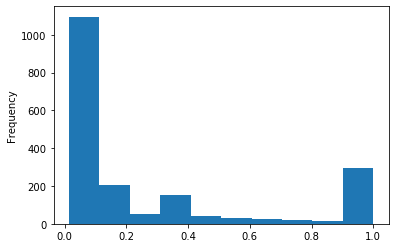

In [98]:
(df_synthetic['p_values']).plot(kind='hist',bins=10)

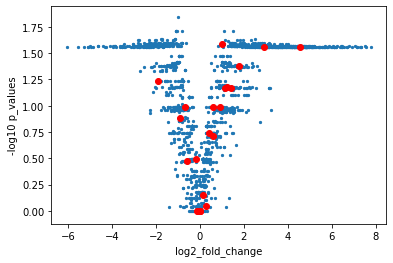

In [100]:
literature = df_synthetic[df_synthetic['UTR_Gene_ID'].isin([
    'Tb927.4.560',
    'Tb927.3.930',
    'Tb927.4.870',
    'Tb927.1.700',
    'Tb927.11.3620',
    'Tb927.10.8490',
    'Tb927.4.2310',
    'Tb927.4.2880',
    'Tb927.7.2660',
    'Tb927.9.2470',
    'Tb927.10.2010',
    'Tb927.11.8990',
    'Tb927.11.14250',
    'Tb927.2.6000',
    'Tb927.8.2780',
    'Tb927.10.3800',
    'Tb927.11.11330',
    'Tb927.11.12100',
    'Tb927.8.6750',
    'Tb927.5.800',
    'Tb927.10.5620'
])]
literature.head()


import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.scatter(df_synthetic['log2_fold_change'], -np.log10(df_synthetic['p_values'] ),s=5)
ax.scatter(literature['log2_fold_change'], -np.log10(literature['p_values']),c='r' ,label='Literature')
plt.xlabel('log2_fold_change')
plt.ylabel('-log10 p_values')
plt.show()

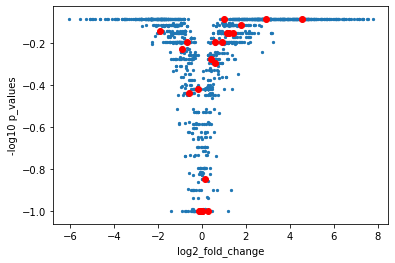

In [101]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.scatter(df_synthetic['log2_fold_change'], -(df_synthetic['fdr'] ),s=5)
ax.scatter(literature['log2_fold_change'], -(literature['fdr']) , c='r' ,label='Literature')
plt.xlabel('log2_fold_change')
plt.ylabel('-log10 p_values')
plt.show()

In [102]:
df_synthetic[ (df_synthetic['log2_fold_change']>0) & (df_synthetic['fdr']<0.1)].shape

(407, 29)

In [103]:
import pandas as pd
df_sense =pd.read_csv('final_sense2.csv',index_col=[0])
tot=0
out = open('sequences_overlap_sense_down_200.fa','w')
for seq in df_sense.sort_values('log2_fold_change',ascending=False).tail(400)['fasta_sequences_overlap_sense']:
    if len(seq.split('\n'))>5:
        #print(seq.split('\n'))
        out.write(seq)
        tot+=1     
out.close() 
print(tot)

tot=0
out = open('sequences_overlap_sense_up_200.fa','w')
for seq in df_sense.sort_values('log2_fold_change',ascending=False).head(400)['fasta_sequences_overlap_sense']:
    if len(seq.split('\n'))>5:
        out.write(seq)
        tot+=1
print(tot)
out.close() 

330
337


In [104]:
df_sense.sort_values('log2_fold_change',ascending=False).tail()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G2,G3,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity
365,Tb927_04_v5.1,1081219,1082560,NA_peak_733_G_Tb927.4.4070,1081390,1082063,Tb927.4.4070,-,673,False,...,5,3,7,10,11,0.027708,0.051812,decreased,-2.825214,1.412607
1590,Tb927_11_v5.1,413960,415099,NA_peak_3989_G_Tb927.11.1400,414733,415187,Tb927.11.1400,+,366,False,...,27,2,14,3,16,0.027708,0.051812,decreased,-2.865671,1.766169
1510,Tb927_10_v5.1,3535290,3537316,NA_peak_2903_G_Tb927.10.14480,3537162,3538129,Tb927.10.14480,-,154,False,...,11,28,48,9,10,0.027281,0.051812,decreased,-3.139836,2.431572
1881,Tb927_11_v5.1,3909046,3910142,NA_peak_4393_G_Tb927.11.14700,3909474,3909578,Tb927.11.14700,-,104,False,...,29,12,9,13,11,0.027708,0.051812,decreased,-3.679411,2.173039
1791,Tb927_11_v5.1,2787020,2788501,NA_peak_4260_G_Tb927.11.10470,2787396,2788990,Tb927.11.10470,+,1105,False,...,42,58,54,57,55,0.027708,0.051812,decreased,-4.080717,3.728572


In [111]:
df_sense.columns#['download_string_overlap']

Index(['Chromosome', 'Peak_Start', 'Peak_End', 'Peak_Name', 'UTR_Start',
       'UTR_End', 'UTR_Gene_ID', 'UTR_Strand', 'UTR_Peak_overlap',
       'is_fully_contained', 'download_string_overlap_sense',
       'fasta_sequences_overlap_sense', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6',
       'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'p_values', 'fdr', 'direction',
       'log2_fold_change', 'log2_avg_intensity'],
      dtype='object')

In [113]:
bed_peaks = open('bla_peaks_final.bed','w')
for index,start,end,chromosome_id in zip(df_sense['Peak_Name'],
                                   df_sense['Peak_Start'],
                                   df_sense['Peak_End'],
                                   df_sense['Chromosome']):
    
    download_string = f'{chromosome_id}\t{start}\t{end}\t{index}\n'
    bed_peaks.write(download_string)
bed_peaks.close()  
!cp bla_peaks_final.bed ../bw_file/    

In [112]:
bed_region = open('bla_regions_final.bed','w')
for index,region_descriptor in zip(df_sense['Peak_Name'],df_sense['download_string_overlap_sense']):
    chromosome_id, start_end, orientation = region_descriptor.split(':')
    start = int(start_end.split('..')[0])
    end = int(start_end.split('..')[1])
    download_string = f'{chromosome_id}\t{start}\t{end}\t{index}\n'
    bed_region.write(download_string)
bed_region.close()  
!cp bla_regions_final.bed ../bw_file/

In [105]:
#df_sense[df_sense['UTR_Gene_ID'].isin(['Tb927.4.2880','Tb927.11.8990'])]

In [106]:
#meme sequences_overlap_sense_up.fa -dna -oc . -nostatus -time 14400 -mod anr -nmotifs 3 -minw 6 -maxw 50 -objfun de -neg sequences_overlap_sense_down.fa -markov_order 0

In [107]:
!rm -r 'meme_300'
!~/miniconda3/envs/meme/bin/meme sequences_overlap_sense_up_200.fa -objfun de -p 16  -markov_order 0 \
-neg sequences_overlap_sense_down_200.fa -dna -mod anr -nmotifs 3 -o 'meme_300'

rm: cannot remove ‘meme_300’: No such file or directory
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           gpu-35
  Local device:         mlx5_bond_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------
Writing results to output directory 'meme_300'.
BACKGROUND: using background model of order 0
PRIMARY (de): n 337 p0 139 p1 99 p2 99
CONTROL (de): n 330 c0 139 c1 95 c2 96
SEQUENCE GROUP USAGE-- Starts/EM: p0 vs c0; Trim: p1 vs c1; pvalue: p2 vs c1,c2; nsites: p0,p1,p2 vs c0,c1,c2
SEEDS: maxwords 60316 highwater mark: seq 89 pos 817
BALANCE: samples 89 chars 61873 nodes 16 chars/node 3867

seqs=   337, min_w= 190, max_w= 2476, total_size=   238389

motif=1
SEED DEPTHS: estimated from d

In [109]:
!rm -r 'meme_300gan'
!~/miniconda3/envs/meme/bin/meme sequences_overlap_sense_down_200.fa -objfun de -p 16  -markov_order 0 \
-neg sequences_overlap_sense_up_200.fa -dna -mod anr -nmotifs 3 -o 'meme_300gan'

rm: cannot remove ‘meme_300gan’: No such file or directory
--------------------------------------------------------------------------
No OpenFabrics connection schemes reported that they were able to be
used on a specific port.  As such, the openib BTL (OpenFabrics
support) will be disabled for this port.

  Local host:           gpu-35
  Local device:         mlx5_bond_0
  Local port:           1
  CPCs attempted:       rdmacm, udcm
--------------------------------------------------------------------------
Writing results to output directory 'meme_300gan'.
Duplicate sequence name. Skipping 'Tb927_08_v5.1:1240248..1241017:r'.
Duplicate sequence name. Skipping 'Tb927_08_v5.1:1856764..1857075:f'.
BACKGROUND: using background model of order 0
PRIMARY (de): n 328 p0 156 p1 86 p2 86
CONTROL (de): n 337 c0 156 c1 90 c2 91
SEQUENCE GROUP USAGE-- Starts/EM: p0 vs c0; Trim: p1 vs c1; pvalue: p2 vs c1,c2; nsites: p0,p1,p2 vs c0,c1,c2
SEEDS: maxwords 60316 highwater mark: seq 100 pos 476
BALANCE:

In [130]:
#!~/miniconda3/envs/meme/bin/meme -version

In [ ]:
#df_synthetic.sort_values('log2_fold_change',ascending=False)

In [ ]:
df_synthetic.sort_values('log2_fold_change',ascending=False)

In [2]:
import pandas as pd
df_sense=pd.read_csv('final_sense2.csv',index_col=[0])
df_sense.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G2,G3,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,2,12,1,11,4,0.224916,0.276130,increased,1.684056,3.540744
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0,16,0,15,2,0.461451,0.522870,decreased,-0.144178,2.093636
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,3,1,1,1,1,0.027281,0.051812,increased,2.843776,2.588555
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,0,0,0,0,0.027708,0.051812,increased,2.969589,1.484794
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0,0,0.317311,0.367044,increased,0.166667,0.083333


In [45]:
gff = pd.read_csv('../bw_file/merged_fixed.gff',
                  sep='\t',comment='#',header=None)
gff = gff[gff.iloc[:,0].isin(df_sense['Chromosome'].unique())]
gff = gff[gff.iloc[:,2]=='five_prime_UTR']
gff.columns = ['Chromosome','source','ann_type','start','end','score','strand','other','note']
gff = gff[gff['source']=='VEuPathDB']
gff.head(10)

,Chromosome,source,ann_type,start,end,score,strand,other,note
2618,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,3244,3246,.,+,.,ID=utr_Tb927.8.110:pseudogenic_transcript_1;Pa...
2637,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,12682,18906,.,+,.,ID=utr_Tb927.8.150:pseudogenic_transcript_1;Pa...
2687,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,46530,46607,.,+,.,ID=utr_Tb927.8.260:pseudogenic_transcript_1;Pa...
2693,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,51024,62485,.,+,.,ID=utr_Tb927.8.270:pseudogenic_transcript_1;Pa...
2718,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,80097,84580,.,+,.,ID=utr_Tb927.8.320:pseudogenic_transcript_1;Pa...
2728,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,90887,90924,.,+,.,ID=utr_Tb927.8.340:pseudogenic_transcript_1;Pa...
2744,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,101170,101222,.,+,.,ID=utr_Tb927.8.370:pseudogenic_transcript_1;Pa...
2749,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,102499,102528,.,+,.,ID=utr_Tb927.8.380:pseudogenic_transcript_1;Pa...
2802,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,129542,132809,.,+,.,ID=utr_Tb927.8.470:pseudogenic_transcript_1;Pa...
2813,Tb927_08_v5.1,VEuPathDB,five_prime_UTR,136692,137806,.,-,.,ID=utr_Tb927.8.480:mRNA_1;Parent=Tb927.8.480:mRNA


In [46]:
df_sense.columns

Index(['Chromosome', 'Peak_Start', 'Peak_End', 'Peak_Name', 'UTR_Start',
       'UTR_End', 'UTR_Gene_ID', 'UTR_Strand', 'UTR_Peak_overlap',
       'is_fully_contained', 'download_string_overlap_sense',
       'fasta_sequences_overlap_sense', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6',
       'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'p_values', 'fdr', 'direction',
       'log2_fold_change', 'log2_avg_intensity'],
      dtype='object')

In [71]:
has_5prime = []
has_5prime_loc = []
from tqdm.auto import tqdm
for index in tqdm(df_sense.index.values):
    Chromosome = df_sense.loc[index]['Chromosome']
    Peak_Start = int(df_sense.loc[index]['Peak_Start'])
    Peak_End = int(df_sense.loc[index]['Peak_End'])
    UTR_Start = int(df_sense.loc[index]['UTR_Start'])
    UTR_End = int(df_sense.loc[index]['UTR_End'])
    UTR_Strand = df_sense.loc[index]['UTR_Strand']
    UTR_Gene_ID = df_sense.loc[index]['UTR_Gene_ID']
   
    if UTR_Strand == '+':
        tmp_gff=gff[ (gff['strand']=='+') &  (gff['Chromosome']==Chromosome)]
        tmp_gff=tmp_gff[ (tmp_gff['start']>UTR_End) & (tmp_gff['start']<Peak_End) ]
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[0]
            five_prime_start = five_prime['start']
            five_prime_end = five_prime['end']
            five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
            has_5prime.append('yes')
            has_5prime_loc.append(f'{five_prime_start}:{five_prime_gene}')
            
        else:
            has_5prime.append('no')
            has_5prime_loc.append('no')
        
        
    if UTR_Strand == '-':
        tmp_gff=gff[ (gff['strand']=='-') &  (gff['Chromosome']==Chromosome)]
        tmp_gff=tmp_gff[ (tmp_gff['end']>Peak_Start) & (tmp_gff['end']<UTR_End) ]
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[0]
            five_prime_start = five_prime['start']
            five_prime_end = five_prime['end']
            five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
            has_5prime.append('yes')
            has_5prime_loc.append(f'{five_prime_end}:{five_prime_gene}')
        else:
            has_5prime.append('no')
            has_5prime_loc.append('no')
assert(len(has_5prime)==df_sense.shape[0])
        
        
        

In [72]:
df_sense['has_5prime']=has_5prime
df_sense['has_5prime_loc']=has_5prime_loc
df_sense.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,1,11,4,0.224916,0.276130,increased,1.684056,3.540744,no,no
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0,15,2,0.461451,0.522870,decreased,-0.144178,2.093636,no,no
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,1,1,1,0.027281,0.051812,increased,2.843776,2.588555,yes,203648:Tb927.1.530.1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,0,0,0.027708,0.051812,increased,2.969589,1.484794,no,no
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0.317311,0.367044,increased,0.166667,0.083333,no,no


In [74]:
df_sense[ (df_sense['log2_fold_change']>0) & (df_sense['fdr']<0.1)]['has_5prime'].value_counts()

yes    844
no     268
Name: has_5prime, dtype: int64

In [75]:
df_sense.to_csv('final_sense3.csv')

In [79]:
df_sense.sort_values('log2_fold_change').tail(50)

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc
1354,Tb927_10_v5.1,2003862,2005142,NA_peak_2698_G_Tb927.10.8050,2004711,2007942,Tb927.10.8050,-,431,False,...,0,0,0,0.027708,0.051812,increased,6.452396,3.226198,yes,2004563:Tb927.10.8040
736,Tb927_07_v5.1,1118094,1119312,NA_peak_1466_G_Tb927.7.4190,1117752,1118173,Tb927.7.4190,+,79,False,...,0,0,0,0.027708,0.051812,increased,6.454361,3.393847,yes,1118963:Tb927.7.4200
226,Tb927_03_v5.1,1031519,1034292,NA_peak_510_G_Tb927.3.3690,1032283,1032991,Tb927.3.3690,+,708,False,...,0,0,0,0.027708,0.051812,increased,6.458115,3.229058,yes,1033145:Tb927.3.3700
1806,Tb927_11_v5.1,2971118,2971590,NA_peak_4276_G_Tb927.11.11080,2971250,2971270,Tb927.11.11080,+,20,False,...,0,0,0,0.027708,0.051812,increased,6.472339,3.402836,yes,2971377:Tb927.11.11090
1146,Tb927_09_v5.1,2071107,2072029,NA_peak_2160.2_G_Tb927.9.13100,2071376,2071493,Tb927.9.13100,+,117,False,...,0,0,0,0.027708,0.051812,increased,6.478720,3.239360,yes,2071649:Tb927.9.13110
302,Tb927_04_v5.1,423101,425052,NA_peak_644_G_Tb927.4.1660,424368,425932,Tb927.4.1660,-,684,False,...,0,0,1,0.027708,0.051812,increased,6.493986,3.413660,yes,424257:Tb927.4.1650
295,Tb927_04_v5.1,334616,336883,NA_peak_634_G_Tb927.4.1270,336235,336559,Tb927.4.1270,-,324,False,...,0,0,3,0.027708,0.051812,increased,6.514033,3.757016,yes,336052:Tb927.4.1260
532,Tb927_06_v5.1,576359,577521,NA_peak_1131_G_Tb927.6.1730,576951,577315,Tb927.6.1730,-,364,False,...,0,1,1,0.027708,0.051812,increased,6.531430,3.599048,yes,576848:Tb927.6.1720
475,Tb927_05_v5.1,1045769,1046786,NA_peak_931_G_Tb927.5.3170,1046516,1048043,Tb927.5.3170,-,270,False,...,0,0,0,0.027708,0.051812,increased,6.548854,3.274427,yes,1046397:Tb927.5.3160
229,Tb927_03_v5.1,1053981,1054980,NA_peak_513_G_Tb927.3.3780,1054018,1054471,Tb927.3.3780,+,453,False,...,0,0,0,0.027708,0.051812,increased,6.551462,3.275731,yes,1054615:Tb927.3.3790


In [64]:
df_synthetic=pd.read_csv('final_synthetic2.csv',index_col=[0])
df_synthetic.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G2,G3,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,9,29,10,35,11,0.104059,0.193052,increased,1.059411,4.746558
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0,27,1,26,2,0.224916,0.331986,increased,0.048872,2.813131
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,1,0,0,0,1,0.027281,0.085912,increased,4.220732,2.443699
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,2,1,0,0,0.102470,0.193052,decreased,-0.694988,0.347494
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0,0,0.027708,0.085912,increased,5.215251,2.607625


In [76]:
has_5prime = []
has_5prime_loc = []
from tqdm.auto import tqdm
for index in tqdm(df_synthetic.index.values):
    Chromosome = df_sense.loc[index]['Chromosome']
    Peak_Start = int(df_sense.loc[index]['Peak_Start'])
    Peak_End = int(df_sense.loc[index]['Peak_End'])
    UTR_Start = int(df_sense.loc[index]['UTR_Start'])
    UTR_End = int(df_sense.loc[index]['UTR_End'])
    UTR_Strand = df_sense.loc[index]['UTR_Strand']
    UTR_Gene_ID = df_sense.loc[index]['UTR_Gene_ID']
   
    if UTR_Strand == '+':
        tmp_gff=gff[ (gff['strand']=='+') &  (gff['Chromosome']==Chromosome)]
        tmp_gff=tmp_gff[ (tmp_gff['start']>UTR_End) & (tmp_gff['start']<Peak_End) ]
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[0]
            five_prime_start = five_prime['start']
            five_prime_end = five_prime['end']
            five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
            has_5prime.append('yes')
            has_5prime_loc.append(f'{five_prime_start}:{five_prime_gene}')
            
        else:
            has_5prime.append('no')
            has_5prime_loc.append('no')
        
        
    if UTR_Strand == '-':
        tmp_gff=gff[ (gff['strand']=='-') &  (gff['Chromosome']==Chromosome)]
        tmp_gff=tmp_gff[ (tmp_gff['end']>Peak_Start) & (tmp_gff['end']<UTR_End) ]
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[0]
            five_prime_start = five_prime['start']
            five_prime_end = five_prime['end']
            five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
            has_5prime.append('yes')
            has_5prime_loc.append(f'{five_prime_end}:{five_prime_gene}')
        else:
            has_5prime.append('no')
            has_5prime_loc.append('no')

assert(len(has_5prime)==df_synthetic.shape[0])
        
        
df_synthetic['has_5prime']=has_5prime
df_synthetic['has_5prime_loc']=has_5prime_loc
df_synthetic.head()       

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,10,35,11,0.104059,0.193052,increased,1.059411,4.746558,no,no
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,1,26,2,0.224916,0.331986,increased,0.048872,2.813131,no,no
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,0,0,1,0.027281,0.085912,increased,4.220732,2.443699,yes,203648:Tb927.1.530.1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,1,0,0,0.102470,0.193052,decreased,-0.694988,0.347494,no,no
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0.027708,0.085912,increased,5.215251,2.607625,no,no


In [80]:
df_synthetic[ (df_synthetic['log2_fold_change']>0) & (df_synthetic['fdr']<0.1)]['has_5prime'].value_counts()

yes    235
no     172
Name: has_5prime, dtype: int64

In [78]:
df_synthetic.to_csv('final_synthetic3.csv')

In [47]:
good_chr = ['Tb927_08_v5.1',
 'Tb927_01_v5.1',
 'Tb927_09_v5.1',
 'Tb927_10_v5.1',
 'Tb927_03_v5.1',
 'Tb927_11_v5.1',
 'Tb927_07_v5.1',
 'Tb927_02_v5.1',
 'Tb927_06_v5.1',
 'Tb927_05_v5.1',
 'Tb927_04_v5.1']

In [48]:
import pandas as pd
df_sense=pd.read_csv('final_sense3.csv',index_col=[0])
df_sense.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,1,11,4,0.224916,0.276130,increased,1.684056,3.540744,no,no
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0,15,2,0.461451,0.522870,decreased,-0.144178,2.093636,no,no
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,1,1,1,0.027281,0.051812,increased,2.843776,2.588555,yes,203648:Tb927.1.530.1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,0,0,0.027708,0.051812,increased,2.969589,1.484794,no,no
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0.317311,0.367044,increased,0.166667,0.083333,no,no


In [49]:
gff = pd.read_csv('../bw_file/merged_fixed.gff',
                  sep='\t',comment='#',header=None)
gff = gff[gff.iloc[:,0].isin(good_chr)]
gff = gff[gff.iloc[:,2]=='five_prime_UTR']
gff.columns = ['Chromosome','source','ann_type','start','end','score','strand','other','note']
gff = gff[gff['source']=='VEuPathDB']
##gff.head(10)


inter_transcript_coord = []
inter_transcript_seq = []
from tqdm.auto import tqdm
for index in tqdm(df_sense.index.values):
    Chromosome = df_sense.loc[index]['Chromosome']
    Peak_Start = int(df_sense.loc[index]['Peak_Start'])
    Peak_End = int(df_sense.loc[index]['Peak_End'])
    UTR_Start = int(df_sense.loc[index]['UTR_Start'])
    UTR_End = int(df_sense.loc[index]['UTR_End'])
    UTR_Strand = df_sense.loc[index]['UTR_Strand']
    UTR_Gene_ID = df_sense.loc[index]['UTR_Gene_ID']
   
    if UTR_Strand == '+':
        tmp_gff=gff[ (gff['strand']=='+') &  (gff['Chromosome']==Chromosome)]
        tmp_gff=tmp_gff[ tmp_gff['start']>=UTR_End ]
        
        #print(tmp_gff)
        
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[0]
            five_prime_start = five_prime['start']
            #five_prime_end = five_prime['end']
            #five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
            inter_transcript_coord.append(f'{Chromosome}:{UTR_End}..{five_prime_start}:f')
            #has_5prime_loc.append(f'{five_prime_start}:{five_prime_gene}')
            
        else:
            inter_transcript_coord.append('not-found')
            #has_5prime_loc.append('no')
        
        
    if UTR_Strand == '-':
        tmp_gff=gff[ (gff['strand']=='-') &  (gff['Chromosome']==Chromosome) ]
        tmp_gff=tmp_gff[ tmp_gff['end']<=UTR_Start ]
        #print(UTR_End)
        #print(tmp_gff)
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[-1]
            #print(five_prime)
            #five_prime_start = five_prime['start']
            five_prime_end = five_prime['end']
            #five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
           # has_5prime.append('yes')
            inter_transcript_coord.append(f'{Chromosome}:{five_prime_end}..{UTR_Start}:r')
        else:
            inter_transcript_coord.append('not-found')
            #has_5prime_loc.append('no')
            
    
#assert(len(inter_transcript_coord)==df_sense.shape[0])
        
        
        

In [50]:
df_sense['inter_transcript_coord'] = inter_transcript_coord

In [149]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

def load_fasta_sequences(fasta_path):
    sequences = {}
    for record in SeqIO.parse(fasta_path, "fasta"):
        sequences[record.id] = record.seq
    return sequences

def extract_region_from_dict(region_descriptor):
    if region_descriptor == 'not-found':
        return 'not-found'
    chromosome_id, start_end, orientation = region_descriptor.split(':')
    
    start = int(start_end.split('..')[0].split('.')[0])
    end = int(start_end.split('..')[1].split('.')[0])
    
    if chromosome_id in sequences:
        sequence = sequences[chromosome_id][start-1:end]
        
        if len(sequence) > 5000:
            if orientation == 'f':  # Forward strand
                sequence = sequence[:5000]  # Take the first 5000 bases.
            elif orientation == 'r':  # Reverse strand
                sequence = sequence[-5000:].reverse_complement()  #        
        
        if orientation == 'r':
            sequence = sequence.reverse_complement()
        seq_record = SeqRecord(sequence, id=region_descriptor, description="")
        return seq_record.format("fasta")
    return None




In [69]:
# Usage with DataFrame
fasta_path = "../TriTrypDB-62_TbruceiTREU927_Genome.fasta"
sequences = load_fasta_sequences(fasta_path)

# Assuming 'df' is your DataFrame and 'coords' is the column with the genomic coordinates
df_sense['inter_transcript_seq'] =df_sense['inter_transcript_coord'].apply(extract_region_from_dict)
df_sense['inter_transcript_seq']=[n.replace('\t','').replace(',','').replace(' ','') for n in df_sense['inter_transcript_seq']]
df_sense['fake']='1'
df_sense.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc,inter_transcript_coord,inter_transcript_seq,fake
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,0.224916,0.276130,increased,1.684056,3.540744,no,no,Tb927_01_v5.1:62886..69661:r,>Tb927_01_v5.1:62886..69661:r\nGGGAAACAGTAAAGG...,1
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0.461451,0.522870,decreased,-0.144178,2.093636,no,no,Tb927_01_v5.1:77979..85611:r,>Tb927_01_v5.1:77979..85611:r\nGGTACTGGTGATGTA...,1
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,0.027281,0.051812,increased,2.843776,2.588555,yes,203648:Tb927.1.530.1,Tb927_01_v5.1:204045..204160:r,>Tb927_01_v5.1:204045..204160:r\nAACGATTTGCAAT...,1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0.027708,0.051812,increased,2.969589,1.484794,no,no,Tb927_01_v5.1:231528..231675:r,>Tb927_01_v5.1:231528..231675:r\nGCTTTTCATTTTG...,1
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0.317311,0.367044,increased,0.166667,0.083333,no,no,Tb927_01_v5.1:263802..263913:r,>Tb927_01_v5.1:263802..263913:r\nTTGTCAAAGCGGC...,1


In [70]:
import numpy as np
np.array(df_sense.columns)

array(['Chromosome', 'Peak_Start', 'Peak_End', 'Peak_Name', 'UTR_Start',
       'UTR_End', 'UTR_Gene_ID', 'UTR_Strand', 'UTR_Peak_overlap',
       'is_fully_contained', 'download_string_overlap_sense',
       'fasta_sequences_overlap_sense', 'B1', 'B2', 'B3', 'B4', 'B5',
       'B6', 'G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'p_values', 'fdr',
       'direction', 'log2_fold_change', 'log2_avg_intensity',
       'has_5prime', 'has_5prime_loc', 'inter_transcript_coord',
       'inter_transcript_seq', 'fake'], dtype=object)

In [71]:
#df_sense['fake']=1
#df_sense = df_sense[list(df_sense.columns)[0:-2]+['inter_transcript_seq','inter_transcript_coord']]

In [72]:
df_sense.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc,inter_transcript_coord,inter_transcript_seq,fake
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,0.224916,0.276130,increased,1.684056,3.540744,no,no,Tb927_01_v5.1:62886..69661:r,>Tb927_01_v5.1:62886..69661:r\nGGGAAACAGTAAAGG...,1
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0.461451,0.522870,decreased,-0.144178,2.093636,no,no,Tb927_01_v5.1:77979..85611:r,>Tb927_01_v5.1:77979..85611:r\nGGTACTGGTGATGTA...,1
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,0.027281,0.051812,increased,2.843776,2.588555,yes,203648:Tb927.1.530.1,Tb927_01_v5.1:204045..204160:r,>Tb927_01_v5.1:204045..204160:r\nAACGATTTGCAAT...,1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0.027708,0.051812,increased,2.969589,1.484794,no,no,Tb927_01_v5.1:231528..231675:r,>Tb927_01_v5.1:231528..231675:r\nGCTTTTCATTTTG...,1
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0.317311,0.367044,increased,0.166667,0.083333,no,no,Tb927_01_v5.1:263802..263913:r,>Tb927_01_v5.1:263802..263913:r\nTTGTCAAAGCGGC...,1


In [73]:
df_sense.iloc[:,0:20].head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,download_string_overlap_sense,fasta_sequences_overlap_sense,B1,B2,B3,B4,B5,B6,G1,G2
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,Tb927_01_v5.1:69661..69903:r,>Tb927_01_v5.1:69661..69903:r\nGGTGTGGAAGGAAAG...,15,42,7,47,7,38,15,2
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,Tb927_01_v5.1:85611..85853:r,>Tb927_01_v5.1:85611..85853:r\nGGTGTGGAAGGAAAG...,15,0,19,0,13,0,9,0
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,Tb927_01_v5.1:204160..204347:r,>Tb927_01_v5.1:204160..204347:r\nCGCGAAGAAAGAT...,31,29,12,17,5,12,1,3
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,Tb927_01_v5.1:232038..232503:r,>Tb927_01_v5.1:232038..232503:r\nACTTCCAGAAAAA...,14,6,9,4,10,3,0,0
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,Tb927_01_v5.1:263913..264334:r,>Tb927_01_v5.1:263913..264334:r\nCACTCGGGTAGGG...,0,1,0,0,0,0,0,0


In [74]:
df_sense=df_sense.rename({
    "has_5prime_loc":"has_DS_splice_site",
    "has_5prime_loc":"DS_splice_site_loc",
    "Peak_Start":"Fragment_Start",
    "Peak_End":"Fragment_End",
    "Peak_Name":"Fragment_Name",
    "UTR_Peak_overlap":"UTR_Fragment_overlap"
    
},axis=1)

In [75]:
np.array(df_sense.columns)

array(['Chromosome', 'Fragment_Start', 'Fragment_End', 'Fragment_Name',
       'UTR_Start', 'UTR_End', 'UTR_Gene_ID', 'UTR_Strand',
       'UTR_Fragment_overlap', 'is_fully_contained',
       'download_string_overlap_sense', 'fasta_sequences_overlap_sense',
       'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'G1', 'G2', 'G3', 'G4', 'G5',
       'G6', 'p_values', 'fdr', 'direction', 'log2_fold_change',
       'log2_avg_intensity', 'has_5prime', 'DS_splice_site_loc',
       'inter_transcript_coord', 'inter_transcript_seq', 'fake'],
      dtype=object)

In [76]:
df_sense.to_csv('final_sense4.tsv',sep='\t')

In [77]:
df_synthetic=pd.read_csv('final_synthetic3.csv',index_col=[0])
df_synthetic

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G4,G5,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,10,35,11,0.104059,0.193052,increased,1.059411,4.746558,no,no
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,1,26,2,0.224916,0.331986,increased,0.048872,2.813131,no,no
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,0,0,1,0.027281,0.085912,increased,4.220732,2.443699,yes,203648:Tb927.1.530.1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,1,0,0,0.102470,0.193052,decreased,-0.694988,0.347494,no,no
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0,0,0.027708,0.085912,increased,5.215251,2.607625,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,Tb927_11_v5.1,4482191,4483499,NA_peak_4469_G_Tb927.11.16830,4483003,4483930,Tb927.11.16830,-,496,False,...,0,0,0,0.027281,0.085912,increased,3.874271,1.937136,yes,4482905:Tb927.11.16820
1937,Tb927_11_v5.1,4496264,4497616,NA_peak_4470_G_Tb927.11.16890,4497174,4497833,Tb927.11.16890,-,442,False,...,2,4,3,0.041227,0.111879,decreased,-1.383201,1.289094,yes,4497076:Tb927.11.16880
1938,Tb927_11_v5.1,4504025,4504891,NA_peak_4471_G_Tb927.11.16900,4504445,4505394,Tb927.11.16900,-,446,False,...,0,0,0,1.000000,1.000000,decreased,0.000000,0.000000,yes,4504343:Tb927.11.16890
1939,Tb927_11_v5.1,4524951,4526327,NA_peak_4473_G_Tb927.11.16970,4524454,4525976,Tb927.11.16970,-,1025,False,...,1,2,0,0.033895,0.102317,decreased,-0.861654,0.597494,no,no


In [78]:
inter_transcript_coord = []
inter_transcript_seq = []
from tqdm.auto import tqdm
for index in tqdm(df_synthetic.index.values):
    Chromosome = df_synthetic.loc[index]['Chromosome']
    Peak_Start = int(df_synthetic.loc[index]['Peak_Start'])
    Peak_End = int(df_synthetic.loc[index]['Peak_End'])
    UTR_Start = int(df_synthetic.loc[index]['UTR_Start'])
    UTR_End = int(df_synthetic.loc[index]['UTR_End'])
    UTR_Strand = df_synthetic.loc[index]['UTR_Strand']
    UTR_Gene_ID = df_synthetic.loc[index]['UTR_Gene_ID']
   
    if UTR_Strand == '+':
        tmp_gff=gff[ (gff['strand']=='+') &  (gff['Chromosome']==Chromosome)]
        tmp_gff=tmp_gff[ tmp_gff['start']>=UTR_End ]
        
        #print(tmp_gff)
        
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[0]
            five_prime_start = five_prime['start']
            #five_prime_end = five_prime['end']
            #five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
            inter_transcript_coord.append(f'{Chromosome}:{UTR_End}..{five_prime_start}:f')
            #has_5prime_loc.append(f'{five_prime_start}:{five_prime_gene}')
            
        else:
            inter_transcript_coord.append('not-found')
            #has_5prime_loc.append('no')
        
        
    if UTR_Strand == '-':
        tmp_gff=gff[ (gff['strand']=='-') &  (gff['Chromosome']==Chromosome)]
        tmp_gff=tmp_gff[ tmp_gff['end']<=UTR_Start ]
        #print(UTR_End)
        #print(tmp_gff)
        if tmp_gff.shape[0] > 0:
            five_prime =  tmp_gff.iloc[-1]
            #print(five_prime)
            #five_prime_start = five_prime['start']
            five_prime_end = five_prime['end']
            #five_prime_gene = five_prime['note'].split('_')[1].split(':')[0]
            #print(UTR_Gene_ID,five_prime_start,five_prime_gene)
            #print(five_prime)
           # has_5prime.append('yes')
            inter_transcript_coord.append(f'{Chromosome}:{five_prime_end}..{UTR_Start}:r')
        else:
            inter_transcript_coord.append('not-found')
            #has_5prime_loc.append('no')
            
    
assert(len(inter_transcript_coord)==df_synthetic.shape[0])

In [79]:
df_synthetic['inter_transcript_coord'] = inter_transcript_coord

In [80]:
df_synthetic['inter_transcript_seq'] = df_synthetic['inter_transcript_coord'].apply(extract_region_from_dict)
df_synthetic.head()

,Chromosome,Peak_Start,Peak_End,Peak_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Peak_overlap,is_fully_contained,...,G6,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,has_5prime_loc,inter_transcript_coord,inter_transcript_seq
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,11,0.104059,0.193052,increased,1.059411,4.746558,no,no,Tb927_01_v5.1:62886..69661:r,>Tb927_01_v5.1:62886..69661:r\nGGGAAACAGTAAAGG...
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,2,0.224916,0.331986,increased,0.048872,2.813131,no,no,Tb927_01_v5.1:77979..85611:r,>Tb927_01_v5.1:77979..85611:r\nGGTACTGGTGATGTA...
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,1,0.027281,0.085912,increased,4.220732,2.443699,yes,203648:Tb927.1.530.1,Tb927_01_v5.1:204045..204160:r,>Tb927_01_v5.1:204045..204160:r\nAACGATTTGCAAT...
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0,0.102470,0.193052,decreased,-0.694988,0.347494,no,no,Tb927_01_v5.1:231528..231675:r,>Tb927_01_v5.1:231528..231675:r\nGCTTTTCATTTTG...
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0,0.027708,0.085912,increased,5.215251,2.607625,no,no,Tb927_01_v5.1:263802..263913:r,>Tb927_01_v5.1:263802..263913:r\nTTGTCAAAGCGGC...


In [81]:
df_synthetic=df_synthetic.rename({
    "has_5prime_loc":"has_DS_splice_site",
    "has_5prime_loc":"DS_splice_site_loc",
    "Peak_Start":"Fragment_Start",
    "Peak_End":"Fragment_End",
    "Peak_Name":"Fragment_Name",
    "UTR_Peak_overlap":"UTR_Fragment_overlap"
    
},axis=1)

In [82]:
df_synthetic['fake']='1'

In [89]:
df_synthetic.to_csv('final_synthetic4.tsv',sep='\t')

In [84]:
df_synthetic.head(50)

,Chromosome,Fragment_Start,Fragment_End,Fragment_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Fragment_overlap,is_fully_contained,...,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,DS_splice_site_loc,inter_transcript_coord,inter_transcript_seq,fake
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,0.104059,0.193052,increased,1.059411,4.746558,no,no,Tb927_01_v5.1:62886..69661:r,>Tb927_01_v5.1:62886..69661:r\nGGGAAACAGTAAAGG...,1
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0.224916,0.331986,increased,0.048872,2.813131,no,no,Tb927_01_v5.1:77979..85611:r,>Tb927_01_v5.1:77979..85611:r\nGGTACTGGTGATGTA...,1
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,0.027281,0.085912,increased,4.220732,2.443699,yes,203648:Tb927.1.530.1,Tb927_01_v5.1:204045..204160:r,>Tb927_01_v5.1:204045..204160:r\nAACGATTTGCAAT...,1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0.102470,0.193052,decreased,-0.694988,0.347494,no,no,Tb927_01_v5.1:231528..231675:r,>Tb927_01_v5.1:231528..231675:r\nGCTTTTCATTTTG...,1
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0.027708,0.085912,increased,5.215251,2.607625,no,no,Tb927_01_v5.1:263802..263913:r,>Tb927_01_v5.1:263802..263913:r\nTTGTCAAAGCGGC...,1
5,Tb927_01_v5.1,307212,308401,NA_peak_132_G_Tb927.1.1080,307301,307362,Tb927.1.1080,+,61,False,...,0.179712,0.272944,increased,0.333333,0.333333,yes,307531:Tb927.1.1090,Tb927_01_v5.1:307362..307531:f,>Tb927_01_v5.1:307362..307531:f\nCAACTTTATGGGG...,1
6,Tb927_01_v5.1,331961,334479,NA_peak_133_G_Tb927.1.1240,332059,334556,Tb927.1.1240,+,2420,False,...,0.058782,0.141733,increased,0.764160,0.382080,no,no,Tb927_01_v5.1:334556..334682:f,>Tb927_01_v5.1:334556..334682:f\nCCTCCTTGTGGAG...,1
7,Tb927_01_v5.1,338860,339936,NA_peak_135_G_Tb927.1.1300,339022,339333,Tb927.1.1300,+,311,False,...,1.000000,1.000000,decreased,0.000000,0.000000,yes,339514:Tb927.1.1310,Tb927_01_v5.1:339333..339514:f,>Tb927_01_v5.1:339333..339514:f\nCCATCAAATCTGT...,1
8,Tb927_01_v5.1,354028,355318,NA_peak_136_G_Tb927.1.1380,354963,356740,Tb927.1.1380,+,355,False,...,0.045500,0.116663,increased,0.666667,0.333333,no,no,Tb927_01_v5.1:356740..356851:f,>Tb927_01_v5.1:356740..356851:f\nTTTATTTTATTTT...,1
9,Tb927_01_v5.1,355435,356028,NA_peak_137_G_Tb927.1.1380,354963,356740,Tb927.1.1380,+,593,True,...,0.025597,0.085912,increased,2.931998,1.465999,no,no,Tb927_01_v5.1:356740..356851:f,>Tb927_01_v5.1:356740..356851:f\nTTTATTTTATTTT...,1


In [155]:
import pandas as pd
gff = pd.read_csv('../bw_file/merged_fixed.gff',
                  sep='\t',comment='#',header=None)
good_chr = ['Tb927_08_v5.1',
 'Tb927_01_v5.1',
 'Tb927_09_v5.1',
 'Tb927_10_v5.1',
 'Tb927_03_v5.1',
 'Tb927_11_v5.1',
 'Tb927_07_v5.1',
 'Tb927_02_v5.1',
 'Tb927_06_v5.1',
 'Tb927_05_v5.1',
 'Tb927_04_v5.1']
gff = gff[gff.iloc[:,0].isin(good_chr)]
gff = gff[ (gff.iloc[:,2]=='five_prime_UTR') | (gff.iloc[:,2]=='three_prime_UTR') ]

gff.columns = ['Chromosome','source','ann_type','start','end','score','strand','other','note']
gff = gff.sort_values(['Chromosome','start'])
gff = gff[gff['source']=='VEuPathDB']

previus = '-'
operon = 0
operon_ids = []
for i,n in enumerate(gff['strand']):
    if previus != n:
        operon+=1
        previus = n
        operon_ids.append(operon)
    else:
        operon_ids.append(operon)
gff['operon_ids']=operon_ids
from tqdm import tqdm
tmp = []
for operon in tqdm(set(operon_ids)):
    tmp_df = gff[gff['operon_ids']==operon].copy()
    if tmp_df['strand'].values[0] == '+':
        if tmp_df.shape[0]>10:
            tmp_df['curr_gene']=[n.split('_')[1].split(':')[0] if '_' in n else 'none' for n in  tmp_df['note']]
            tmp_df['next_start']=tmp_df['start'].shift(-1)
            tmp_df['next_ann_type']=tmp_df['ann_type'].shift(-1)
            tmp_df['next_note']=tmp_df['note'].shift(-1)
            tmp_df['next_gene']=tmp_df['curr_gene'].shift(-1)
            tmp_df = tmp_df[
                (tmp_df['ann_type']=='three_prime_UTR') & (tmp_df['next_ann_type']=='five_prime_UTR')]
            tmp_df = tmp_df[
                tmp_df['curr_gene']!=tmp_df['next_gene']]
            tmp_df['region_id']=tmp_df['curr_gene']+'_'+tmp_df['next_gene']
            tmp_df['location']=tmp_df['Chromosome']+':'+tmp_df['end'].astype(str)+'..'+tmp_df['next_start'].astype(str)+':f'

            tmp_df=tmp_df[~tmp_df['next_note'].str.contains('pseudogenic')]
            tmp_df=tmp_df[~tmp_df['note'].str.contains('pseudogenic')]
            tmp.append(tmp_df)
            #print(tmp_df.shape)
            #break

    else:
        if tmp_df.shape[0]>10:
            tmp_df['curr_gene']=[n.split('_')[1].split(':')[0] if '_' in n else 'none' for n in  tmp_df['note']]
            tmp_df['next_start']=tmp_df['start'].shift(-1)
            tmp_df['next_ann_type']=tmp_df['ann_type'].shift(-1)
            tmp_df['next_note']=tmp_df['note'].shift(-1)
            tmp_df['next_gene']=tmp_df['curr_gene'].shift(-1)
            tmp_df = tmp_df[
                (tmp_df['ann_type']=='five_prime_UTR') & (tmp_df['next_ann_type']=='three_prime_UTR')]
            tmp_df = tmp_df[
                tmp_df['curr_gene']!=tmp_df['next_gene']]
            tmp_df['region_id']=tmp_df['curr_gene']+'_'+tmp_df['next_gene']
            tmp_df['location']=tmp_df['Chromosome']+':'+tmp_df['end'].astype(str)+'..'+tmp_df['next_start'].astype(str)+':r'
            tmp_df=tmp_df[~tmp_df['next_note'].str.contains('pseudogenic')]
            tmp_df=tmp_df[~tmp_df['note'].str.contains('pseudogenic')]
            tmp.append(tmp_df) 


100%|██████████| 258/258 [00:01<00:00, 215.54it/s]


In [156]:
tmp=pd.concat(tmp)
tmp=tmp.sort_values(['Chromosome','start'])
print(tmp.shape)
tmp.head(5)
#tmp.sort_values(['Chromosome','start']).head(50)

(5072, 17)


,Chromosome,source,ann_type,start,end,score,strand,other,note,operon_ids,curr_gene,next_start,next_ann_type,next_note,next_gene,region_id,location
9990,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,62837,62886,.,-,.,ID=utr_Tb927.1.120:mRNA_2;Parent=Tb927.1.120:mRNA,0,Tb927.1.120,69661.0,three_prime_UTR,ID=utr_Tb927.1.180:mRNA_1;Parent=Tb927.1.180:mRNA,Tb927.1.180,Tb927.1.120_Tb927.1.180,Tb927_01_v5.1:62886..69661.0:r
10177,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,204018,204045,.,-,.,ID=utr_Tb927.1.530.2:mRNA_2;Parent=Tb927.1.530...,6,Tb927.1.530.2,204249.0,three_prime_UTR,ID=utr_Tb927.1.540:mRNA_1;Parent=Tb927.1.540:mRNA,Tb927.1.540,Tb927.1.530.2_Tb927.1.540,Tb927_01_v5.1:204045..204249.0:r
10193,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,207808,208483,.,-,.,ID=utr_Tb927.1.540:mRNA_2;Parent=Tb927.1.540:mRNA,6,Tb927.1.540,208607.0,three_prime_UTR,ID=utr_Tb927.1.560:mRNA_1;Parent=Tb927.1.560:mRNA,Tb927.1.560,Tb927.1.540_Tb927.1.560,Tb927_01_v5.1:208483..208607.0:r
10199,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,210032,210085,.,-,.,ID=utr_Tb927.1.560:mRNA_2;Parent=Tb927.1.560:mRNA,6,Tb927.1.560,210203.0,three_prime_UTR,ID=utr_Tb927.1.570:mRNA_1;Parent=Tb927.1.570:mRNA,Tb927.1.570,Tb927.1.560_Tb927.1.570,Tb927_01_v5.1:210085..210203.0:r
10205,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,211420,211427,.,-,.,ID=utr_Tb927.1.570:mRNA_2;Parent=Tb927.1.570:mRNA,6,Tb927.1.570,211572.0,three_prime_UTR,ID=utr_Tb927.1.580:mRNA_1;Parent=Tb927.1.580:mRNA,Tb927.1.580,Tb927.1.570_Tb927.1.580,Tb927_01_v5.1:211427..211572.0:r


In [157]:
intergenic_regions = tmp.copy()

In [158]:
fasta_path = "../TriTrypDB-62_TbruceiTREU927_Genome.fasta"
sequences = load_fasta_sequences(fasta_path)

# Assuming 'df' is your DataFrame and 'coords' is the column with the genomic coordinates
intergenic_regions['inter_transcript_seq'] =intergenic_regions['location'].apply(extract_region_from_dict)
intergenic_regions['fake']='1'
intergenic_regions

,Chromosome,source,ann_type,start,end,score,strand,other,note,operon_ids,curr_gene,next_start,next_ann_type,next_note,next_gene,region_id,location,inter_transcript_seq,fake
9990,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,62837,62886,.,-,.,ID=utr_Tb927.1.120:mRNA_2;Parent=Tb927.1.120:mRNA,0,Tb927.1.120,69661.0,three_prime_UTR,ID=utr_Tb927.1.180:mRNA_1;Parent=Tb927.1.180:mRNA,Tb927.1.180,Tb927.1.120_Tb927.1.180,Tb927_01_v5.1:62886..69661.0:r,>Tb927_01_v5.1:62886..69661.0:r\nGGGAAACAGTAAA...,1
10177,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,204018,204045,.,-,.,ID=utr_Tb927.1.530.2:mRNA_2;Parent=Tb927.1.530...,6,Tb927.1.530.2,204249.0,three_prime_UTR,ID=utr_Tb927.1.540:mRNA_1;Parent=Tb927.1.540:mRNA,Tb927.1.540,Tb927.1.530.2_Tb927.1.540,Tb927_01_v5.1:204045..204249.0:r,>Tb927_01_v5.1:204045..204249.0:r\nGTGTAACGCAG...,1
10193,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,207808,208483,.,-,.,ID=utr_Tb927.1.540:mRNA_2;Parent=Tb927.1.540:mRNA,6,Tb927.1.540,208607.0,three_prime_UTR,ID=utr_Tb927.1.560:mRNA_1;Parent=Tb927.1.560:mRNA,Tb927.1.560,Tb927.1.540_Tb927.1.560,Tb927_01_v5.1:208483..208607.0:r,>Tb927_01_v5.1:208483..208607.0:r\nTATTTTGTCTT...,1
10199,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,210032,210085,.,-,.,ID=utr_Tb927.1.560:mRNA_2;Parent=Tb927.1.560:mRNA,6,Tb927.1.560,210203.0,three_prime_UTR,ID=utr_Tb927.1.570:mRNA_1;Parent=Tb927.1.570:mRNA,Tb927.1.570,Tb927.1.560_Tb927.1.570,Tb927_01_v5.1:210085..210203.0:r,>Tb927_01_v5.1:210085..210203.0:r\nGATTTGATTAT...,1
10205,Tb927_01_v5.1,VEuPathDB,five_prime_UTR,211420,211427,.,-,.,ID=utr_Tb927.1.570:mRNA_2;Parent=Tb927.1.570:mRNA,6,Tb927.1.570,211572.0,three_prime_UTR,ID=utr_Tb927.1.580:mRNA_1;Parent=Tb927.1.580:mRNA,Tb927.1.580,Tb927.1.570_Tb927.1.580,Tb927_01_v5.1:211427..211572.0:r,>Tb927_01_v5.1:211427..211572.0:r\nTAGTGTTTTTT...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55161,Tb927_11_v5.1,VEuPathDB,five_prime_UTR,4520301,4520422,.,-,.,ID=utr_Tb927.11.16950:mRNA_1;Parent=Tb927.11.1...,240,Tb927.11.16950,4520695.0,three_prime_UTR,ID=utr_Tb927.11.16960:mRNA_1;Parent=Tb927.11.1...,Tb927.11.16960,Tb927.11.16950_Tb927.11.16960,Tb927_11_v5.1:4520422..4520695.0:r,>Tb927_11_v5.1:4520422..4520695.0:r\nACGTGTATA...,1
55171,Tb927_11_v5.1,VEuPathDB,five_prime_UTR,4523250,4524348,.,-,.,ID=utr_Tb927.11.16960:mRNA_2;Parent=Tb927.11.1...,240,Tb927.11.16960,4524454.0,three_prime_UTR,ID=utr_Tb927.11.16970:mRNA_1;Parent=Tb927.11.1...,Tb927.11.16970,Tb927.11.16960_Tb927.11.16970,Tb927_11_v5.1:4524348..4524454.0:r,>Tb927_11_v5.1:4524348..4524454.0:r\nTAAAAATAT...,1
55188,Tb927_11_v5.1,VEuPathDB,five_prime_UTR,4528427,4528662,.,-,.,ID=utr_Tb927.11.16980:mRNA_1;Parent=Tb927.11.1...,240,Tb927.11.16980,4528567.0,three_prime_UTR,ID=utr_Tb927.11.16990:mRNA_1;Parent=Tb927.11.1...,Tb927.11.16990,Tb927.11.16980_Tb927.11.16990,Tb927_11_v5.1:4528662..4528567.0:r,>Tb927_11_v5.1:4528662..4528567.0:r\n,1
55193,Tb927_11_v5.1,VEuPathDB,five_prime_UTR,4530920,4531050,.,-,.,ID=utr_Tb927.11.16990:mRNA_2;Parent=Tb927.11.1...,240,Tb927.11.16990,4531326.0,three_prime_UTR,ID=utr_Tb927.11.17000:mRNA_1;Parent=Tb927.11.1...,Tb927.11.17000,Tb927.11.16990_Tb927.11.17000,Tb927_11_v5.1:4531050..4531326.0:r,>Tb927_11_v5.1:4531050..4531326.0:r\nGAAAAAAAA...,1


In [159]:
intergenic_regions['len']=[len(n) for n in intergenic_regions['inter_transcript_seq']]

In [160]:
print(intergenic_regions.shape)
intergenic_regions=intergenic_regions[intergenic_regions['len']<5000]
print(intergenic_regions.shape)

(5072, 20)
(5042, 20)


In [161]:
intergenic_regions.to_csv('intergenic_regions.tsv',sep='\t')

In [24]:
#intergenic_regions = intergenic_regions[['inter_transcript_seq','Chromosome', 'start', 'end', 'strand', 'region_id', 'location',
#        'fake']]

In [38]:
print(1)

1


In [39]:
intergenic_regions

,Chromosome,start,end,strand,region_id,location,inter_transcript_seq,fake,len
1,Tb927_01_v5.1,8566,12734,r,Tb927.1.05_Tb927.1.20,Tb927_01_v5.1:8566..12734:r,>Tb927_01_v5.1:8566..12734:r\nGATGAAACTGAAAGAG...,1,4268
2,Tb927_01_v5.1,41394,41686,r,Tb927.1.20_Tb927.1.40,Tb927_01_v5.1:41394..41686:r,>Tb927_01_v5.1:41394..41686:r\nATGAATCGGGTGAAA...,1,328
3,Tb927_01_v5.1,41926,43910,r,Tb927.1.40_Tb927.1.60,Tb927_01_v5.1:41926..43910:r,>Tb927_01_v5.1:41926..43910:r\nTATGTTTCTGGTTGC...,1,2049
5,Tb927_01_v5.1,47043,50428,r,Tb927.1.60_Tb927.1.70,Tb927_01_v5.1:47043..50428:r,>Tb927_01_v5.1:47043..50428:r\nAATTGTGCTCTTGTT...,1,3473
6,Tb927_01_v5.1,50429,52206,r,Tb927.1.70_Tb927.1.90,Tb927_01_v5.1:50429..52206:r,>Tb927_01_v5.1:50429..52206:r\nTATGTCAAGAGCAAA...,1,1838
...,...,...,...,...,...,...,...,...,...
13911,Tb927_11_v5.1,5014070,5017411,r,Tb927.11.18320.1_Tb927.11.18370.1,Tb927_11_v5.1:5014070..5017411:r,>Tb927_11_v5.1:5014070..5017411:r\nACCACAAACAG...,1,3432
13913,Tb927_11_v5.1,5050375,5050720,r,Tb927.11.18380.1_Tb927.11.18440,Tb927_11_v5.1:5050375..5050720:r,>Tb927_11_v5.1:5050375..5050720:r\nATTTGGTGTGA...,1,386
13914,Tb927_11_v5.1,5053957,5055287,r,Tb927.11.18440_Tb927.11.18450,Tb927_11_v5.1:5053957..5055287:r,>Tb927_11_v5.1:5053957..5055287:r\nTATGTTGTTAA...,1,1388
13917,Tb927_11_v5.1,5130296,5135006,f,Tb927.11.18600.1_Tb927.11.18620.1,Tb927_11_v5.1:5130296..5135006:f,>Tb927_11_v5.1:5130296..5135006:f\nAGAAGCCCCCC...,1,4824


In [40]:
intergenic_regions

,Chromosome,start,end,strand,region_id,location,inter_transcript_seq,fake,len
1,Tb927_01_v5.1,8566,12734,r,Tb927.1.05_Tb927.1.20,Tb927_01_v5.1:8566..12734:r,>Tb927_01_v5.1:8566..12734:r\nGATGAAACTGAAAGAG...,1,4268
2,Tb927_01_v5.1,41394,41686,r,Tb927.1.20_Tb927.1.40,Tb927_01_v5.1:41394..41686:r,>Tb927_01_v5.1:41394..41686:r\nATGAATCGGGTGAAA...,1,328
3,Tb927_01_v5.1,41926,43910,r,Tb927.1.40_Tb927.1.60,Tb927_01_v5.1:41926..43910:r,>Tb927_01_v5.1:41926..43910:r\nTATGTTTCTGGTTGC...,1,2049
5,Tb927_01_v5.1,47043,50428,r,Tb927.1.60_Tb927.1.70,Tb927_01_v5.1:47043..50428:r,>Tb927_01_v5.1:47043..50428:r\nAATTGTGCTCTTGTT...,1,3473
6,Tb927_01_v5.1,50429,52206,r,Tb927.1.70_Tb927.1.90,Tb927_01_v5.1:50429..52206:r,>Tb927_01_v5.1:50429..52206:r\nTATGTCAAGAGCAAA...,1,1838
...,...,...,...,...,...,...,...,...,...
13911,Tb927_11_v5.1,5014070,5017411,r,Tb927.11.18320.1_Tb927.11.18370.1,Tb927_11_v5.1:5014070..5017411:r,>Tb927_11_v5.1:5014070..5017411:r\nACCACAAACAG...,1,3432
13913,Tb927_11_v5.1,5050375,5050720,r,Tb927.11.18380.1_Tb927.11.18440,Tb927_11_v5.1:5050375..5050720:r,>Tb927_11_v5.1:5050375..5050720:r\nATTTGGTGTGA...,1,386
13914,Tb927_11_v5.1,5053957,5055287,r,Tb927.11.18440_Tb927.11.18450,Tb927_11_v5.1:5053957..5055287:r,>Tb927_11_v5.1:5053957..5055287:r\nTATGTTGTTAA...,1,1388
13917,Tb927_11_v5.1,5130296,5135006,f,Tb927.11.18600.1_Tb927.11.18620.1,Tb927_11_v5.1:5130296..5135006:f,>Tb927_11_v5.1:5130296..5135006:f\nAGAAGCCCCCC...,1,4824


In [74]:
a=0
out = open('ag_all.txt','w')
for n in intergenic_regions['inter_transcript_seq']:
    if len(n) < 1000:
        a+=1
        n=n.replace('\n','')[-20:]
        if len(n) !=20:
            pass
        else:
            out.write(n[-20:]+'\n')
out.close()
print(a)

4608


In [68]:
intergenic_regions.shape

(8261, 9)

In [5]:
import pandas as pd
df_sense = pd.read_csv('final_sense4.tsv',sep='\t',index_col=[0])
df_sense.head(50)

,Chromosome,Fragment_Start,Fragment_End,Fragment_Name,UTR_Start,UTR_End,UTR_Gene_ID,UTR_Strand,UTR_Fragment_overlap,is_fully_contained,...,p_values,fdr,direction,log2_fold_change,log2_avg_intensity,has_5prime,DS_splice_site_loc,inter_transcript_coord,inter_transcript_seq,fake
0,Tb927_01_v5.1,69142,70745,NA_peak_118_G_Tb927.1.180,69661,69903,Tb927.1.180,-,242,False,...,0.224916,0.276130,increased,1.684056,3.540744,no,no,Tb927_01_v5.1:62886..69661:r,>Tb927_01_v5.1:62886..69661:r\nGGGAAACAGTAAAGG...,1
1,Tb927_01_v5.1,85602,86127,NA_peak_120_G_Tb927.1.220,85611,85853,Tb927.1.220,-,242,False,...,0.461451,0.522870,decreased,-0.144178,2.093636,no,no,Tb927_01_v5.1:77979..85611:r,>Tb927_01_v5.1:77979..85611:r\nGGTACTGGTGATGTA...,1
2,Tb927_01_v5.1,202075,204347,NA_peak_125_G_Tb927.1.540,204160,204417,Tb927.1.540,-,187,False,...,0.027281,0.051812,increased,2.843776,2.588555,yes,203648:Tb927.1.530.1,Tb927_01_v5.1:204045..204160:r,>Tb927_01_v5.1:204045..204160:r\nAACGATTTGCAAT...,1
3,Tb927_01_v5.1,232038,232950,NA_peak_126_G_Tb927.1.700,231675,232503,Tb927.1.700,-,465,False,...,0.027708,0.051812,increased,2.969589,1.484794,no,no,Tb927_01_v5.1:231528..231675:r,>Tb927_01_v5.1:231528..231675:r\nGCTTTTCATTTTG...,1
4,Tb927_01_v5.1,263873,264334,NA_peak_129_G_Tb927.1.880,263913,264383,Tb927.1.880,-,421,False,...,0.317311,0.367044,increased,0.166667,0.083333,no,no,Tb927_01_v5.1:263802..263913:r,>Tb927_01_v5.1:263802..263913:r\nTTGTCAAAGCGGC...,1
5,Tb927_01_v5.1,307212,308401,NA_peak_132_G_Tb927.1.1080,307301,307362,Tb927.1.1080,+,61,False,...,0.317311,0.367044,increased,0.166667,0.083333,yes,307531:Tb927.1.1090,Tb927_01_v5.1:307362..307531:f,>Tb927_01_v5.1:307362..307531:f\nCAACTTTATGGGG...,1
6,Tb927_01_v5.1,331961,334479,NA_peak_133_G_Tb927.1.1240,332059,334556,Tb927.1.1240,+,2420,False,...,0.102470,0.145498,increased,0.597494,0.298747,no,no,Tb927_01_v5.1:334556..334682:f,>Tb927_01_v5.1:334556..334682:f\nCCTCCTTGTGGAG...,1
7,Tb927_01_v5.1,338860,339936,NA_peak_135_G_Tb927.1.1300,339022,339333,Tb927.1.1300,+,311,False,...,0.026014,0.051812,increased,0.982666,3.131725,yes,339514:Tb927.1.1310,Tb927_01_v5.1:339333..339514:f,>Tb927_01_v5.1:339333..339514:f\nCCATCAAATCTGT...,1
8,Tb927_01_v5.1,354028,355318,NA_peak_136_G_Tb927.1.1380,354963,356740,Tb927.1.1380,+,355,False,...,1.000000,1.000000,decreased,0.000000,0.000000,no,no,Tb927_01_v5.1:356740..356851:f,>Tb927_01_v5.1:356740..356851:f\nTTTATTTTATTTT...,1
9,Tb927_01_v5.1,355435,356028,NA_peak_137_G_Tb927.1.1380,354963,356740,Tb927.1.1380,+,593,True,...,1.000000,1.000000,decreased,0.000000,0.000000,no,no,Tb927_01_v5.1:356740..356851:f,>Tb927_01_v5.1:356740..356851:f\nTTTATTTTATTTT...,1


In [4]:
df_sense.shape

(1941, 34)

In [75]:
out = open('ag_bla.txt','w')
a=0
for n in df_sense['inter_transcript_seq']:
    if len(n) < 1000:
        a+=1
        n=n.replace('\n','')[-20:]
        if len(n) !=20:
            pass
        else:
            out.write(n[-20:]+'\n')
    
out.close()
print(a)


1774
